### 调参
1、只更新生成器的rnn参数，不更新linear out仿射层

2、改变温度参数到0.5

3、不采用self attention

In [4]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.init as weight_init
import numpy as np
from time import time
import data
import sys
from metrics import Metrics
import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = torch.device('cuda:0')


In [5]:
def config_HRED():
    conf = {
    'maxlen':20, # maximum utterance length
    'diaglen':10, # how many utterance kept in the context window

# Model Arguments
    'emb_size':200, # size of word embeddings
    'n_hidden':300,
    'gru_hidden_utter_encode':300, # number of hidden units of utterance encoder
    'gru_hidden_context_encode':300,
    'gru_hidden_decode':300,
    'n_layers':1, # number of layers
    'gru_hidden_dis_rel':300,
    'filter_channel_dis_rel':[100, 100],
    'filter_sizes_dis_rel':[2, 3],
    'linear_dis_rel':300,
    'noise_radius':0.2, # stdev of noise for autoencoder (regularizer)
    'lambda_gp':10, # Gradient penalty lambda hyperparameter.
    'temp':1.0, # softmax temperature (lower --> more discrete)
    'dropout':0.5, # dropout applied to layers (0 = no dropout)

# Training Arguments
    'batch_size':32,
    'epochs':100, # maximum number of epochs
    'min_epochs':2, # minimum number of epochs to train for

    'n_iters_d':3, # number of discriminator iterations in training
    'lr_ae':0.001, # autoencoder learning rate
    'lr_gan_g':1e-04, # generator learning rate
    'lr_gan_d_rel':1e-04, # critic/discriminator learning rate
#     'lr':0.001, # autoencoder learning rate
    'beta1':0.9, # beta1 for adam
    'clip':1.0,  # gradient clipping, max norm
    'gan_clamp':0.01,  # WGAN clamp (Do not use clamp when you apply gradient penelty             
    }
    return conf 

config = config_HRED()

In [6]:
def gData(data):
    tensor=data
    if isinstance(data, np.ndarray):
        tensor = torch.from_numpy(data)
    tensor=tensor.to(DEVICE)
    return tensor

def gVar(data):
    return gData(data)
def print_flush(data, args=None):
    if args == None:
        print(data)
    else:
        print(data, args)
    sys.stdout.flush()
    
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    if torch.cuda.is_available():
        U = U.to(DEVICE)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def get_fixed_temperature(temper, i, N, adapt):
    if adapt == 'no':
        temper_var_np = temper  # no increase
    elif adapt == 'lin':
        temper_var_np = 1 + i / (N - 1) * (temper - 1)  # linear increase
    elif adapt == 'exp':
        temper_var_np = temper ** (i / N)  # exponential increase
    elif adapt == 'log':
        temper_var_np = 1 + (temper - 1) / np.log(N) * np.log(i + 1)  # logarithm increase
    return temper_var_np
    
def indexes2sent(indexes, vocab, eos_tok, ignore_tok=0): 
    '''indexes: numpy array'''
    def revert_sent(indexes, ivocab, eos_tok, ignore_tok=0):
        toks=[]
        length=0
        indexes=filter(lambda i: i!=ignore_tok, indexes)
        for idx in indexes:
            toks.append(ivocab[idx])
            length+=1
            if idx == eos_tok:
                break
        return ' '.join(toks), length
    
    ivocab = {v: k for k, v in vocab.items()}
    if indexes.ndim==1:# one sentence
        return revert_sent(indexes, ivocab, eos_tok, ignore_tok)
    else:# dim>1
        sentences=[] # a batch of sentences
        lens=[]
        for inds in indexes:
            sentence, length = revert_sent(inds, ivocab, eos_tok, ignore_tok)
            sentences.append(sentence)
            lens.append(length)
        return sentences, lens

In [7]:
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, mask=None):

        attn = torch.bmm(q, k.transpose(1, 2))
        attn = attn / self.temperature

        if mask is not None:
            attn = attn.masked_fill(mask, -np.inf)

        attn = self.softmax(attn)
        attn = self.dropout(attn)
        output = torch.bmm(attn, v)

        return output, attn
    
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k)
        self.w_ks = nn.Linear(d_model, n_head * d_k)
        self.w_vs = nn.Linear(d_model, n_head * d_v)
        nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_v)))

        self.attention = ScaledDotProductAttention(temperature=np.power(d_k, 0.5))
        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(n_head * d_v, d_model)
        nn.init.xavier_normal_(self.fc.weight)

        self.dropout = nn.Dropout(dropout)


    def forward(self, q, k, v):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head

        sz_b, len_q, _ = q.size()
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()

        residual = q

        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv

#         mask = mask.repeat(n_head, 1, 1) # (n*b) x .. x ..
        output, attn = self.attention(q, k, v)

        output = output.view(n_head, sz_b, len_q, d_v)
        output = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)

        output = self.dropout(self.fc(output))
        output = self.layer_norm(output + residual)

        return output


In [8]:
class Encoder(nn.Module):
    def __init__(self, embedder, input_size, hidden_size, bidirectional, n_layers, noise_radius=0.2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.noise_radius=noise_radius
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        assert type(self.bidirectional)==bool
        self.embedding = embedder
        self.rnn = nn.GRU(input_size, hidden_size, n_layers, batch_first=True, bidirectional=bidirectional)
        self.init_weights()
        
    def init_weights(self):
        for w in self.rnn.parameters(): 
            if w.dim()>1:
                weight_init.orthogonal_(w)
                
    def store_grad_norm(self, grad):
        norm = torch.norm(grad, 2, 1)
        self.grad_norm = norm.detach().data.mean()
        return grad
    
    def forward(self, inputs, input_lens=None, noise=False):
        if inputs.dim() == 2:
            inputs=self.embedding(inputs)
        else:
            inputs = torch.bmm(inputs, self.embedding.weight.repeat(inputs.size(0), 1, 1))
#         else:
#             inputs = torch.bmm(inputs, self.embedding.weight.repeat(inputs.size(0), 1, 1))
        batch_size, seq_len, emb_size=inputs.size()
#         inputs=F.dropout(inputs, 0.5, self.training)
        if input_lens is not None:
            input_lens_sorted, indices = input_lens.sort(descending=True)
            inputs_sorted = inputs.index_select(0, indices)
            inputs = pack_padded_sequence(inputs_sorted, input_lens_sorted.data.tolist(), batch_first=True)
        init_hidden = gVar(torch.zeros(self.n_layers*(1+self.bidirectional), batch_size, self.hidden_size))
        hids, h_n = self.rnn(inputs, init_hidden)
        if input_lens is not None:
            _, inv_indices = indices.sort()
            hids, lens = pad_packed_sequence(hids, batch_first=True)  
            hids = hids.index_select(0, inv_indices)
            h_n = h_n.index_select(1, inv_indices)
        h_n = h_n.view(self.n_layers, (1+self.bidirectional), batch_size, self.hidden_size)
        h_n = h_n[-1]
        enc = h_n.transpose(1,0).contiguous().view(batch_size,-1)
#         if noise and self.noise_radius > 0:
#             gauss_noise = gVar(torch.normal(means=torch.zeros(enc.size()),std=self.noise_radius))
#             enc = enc + gauss_noise
            
        return enc, hids
    
class ContextEncoder(nn.Module):
    def __init__(self, utt_encoder, input_size, hidden_size, n_layers=1, noise_radius=0.2):
        super(ContextEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.noise_radius=noise_radius
        
        self.n_layers = n_layers
        
        self.utt_encoder=utt_encoder
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.init_weights()
        
    def init_weights(self):
        for w in self.rnn.parameters(): # initialize the gate weights with orthogonal
            if w.dim()>1:
                weight_init.orthogonal_(w)
    
    def store_grad_norm(self, grad):
        norm = torch.norm(grad, 2, 1)
        self.grad_norm = norm.detach().data.mean()
        return grad

    def forward(self, context, context_lens, utt_lens, floors, noise=False): 
        batch_size, max_context_len, max_utt_len = context.size()
        utts=context.view(-1, max_utt_len) 
        utt_lens=utt_lens.view(-1)
        utt_encs,_ = self.utt_encoder(utts, utt_lens)
        utt_encs = utt_encs.view(batch_size, max_context_len, -1)
        floor_one_hot = gVar(torch.zeros(floors.numel(), 2))
        floor_one_hot.data.scatter_(1, floors.view(-1, 1), 1)
        floor_one_hot = floor_one_hot.view(-1, max_context_len, 2)
        utt_floor_encs = torch.cat([utt_encs, floor_one_hot], 2) 
#         utt_floor_encs=F.dropout(utt_floor_encs, 0.25, self.training)
        context_lens_sorted, indices = context_lens.sort(descending=True)
        utt_floor_encs = utt_floor_encs.index_select(0, indices)
        utt_floor_encs = pack_padded_sequence(utt_floor_encs, context_lens_sorted.data.tolist(), batch_first=True)
        
        init_hidden=gVar(torch.zeros(1, batch_size, self.hidden_size))
        hids, h_n = self.rnn(utt_floor_encs, init_hidden)
        
        _, inv_indices = indices.sort()
        h_n = h_n.index_select(1, inv_indices)
        enc = h_n.transpose(1,0).contiguous().view(batch_size, -1)

#         if noise and self.noise_radius > 0:
#             gauss_noise = gVar(torch.normal(means=torch.zeros(enc.size()),std=self.noise_radius))
#             enc = enc + gauss_noise
        return enc

class ContextEncoder_self_attention(nn.Module):
    def __init__(self, utt_encoder, input_size, hidden_size, n_head, n_self,
                 n_layers=1, noise_radius=0.2):
        super(ContextEncoder_self_attention, self).__init__()
        self.hidden_size = hidden_size
        self.noise_radius=noise_radius
        self.n_layers = n_layers
        self.self_attention = MultiHeadAttention(n_head, hidden_size, n_self, n_self)
        self.utt_encoder=utt_encoder
#         self.linear = nn.Linear(input_size, hidden_size)
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.init_weights()
        
    def init_weights(self):
        for w in self.rnn.parameters(): # initialize the gate weights with orthogonal
            if w.dim()>1:
                weight_init.orthogonal_(w)
    
    def store_grad_norm(self, grad):
        norm = torch.norm(grad, 2, 1)
        self.grad_norm = norm.detach().data.mean()
        return grad

    def forward(self, context, context_lens, utt_lens, floors, noise=False): 
        batch_size, max_context_len, max_utt_len = context.size()
        utts=context.view(-1, max_utt_len)
        utt_lens=utt_lens.view(-1)
        utt_encs,_ = self.utt_encoder(utts, utt_lens) 
        utt_encs = utt_encs.view(batch_size, max_context_len, -1)
        floor_one_hot = gVar(torch.zeros(floors.numel(), 2))
        floor_one_hot.data.scatter_(1, floors.view(-1, 1), 1)
        floor_one_hot = floor_one_hot.view(-1, max_context_len, 2)
        utt_floor_encs = torch.cat([utt_encs, floor_one_hot], 2)
#         utt_floor_encs = self.linear(utt_floor_encs)
#         utt_floor_encs=F.dropout(utt_floor_encs, 0.25, self.training)
#         final_out = self.linear(maxpool)
        context_lens_sorted, indices = context_lens.sort(descending=True)
        utt_floor_encs = utt_floor_encs.index_select(0, indices)
        utt_floor_encs = pack_padded_sequence(utt_floor_encs, context_lens_sorted.data.tolist(), batch_first=True)
        init_hidden = gVar(torch.zeros(1, batch_size, self.hidden_size))
        hids, h_n = self.rnn(utt_floor_encs, init_hidden)
        hids, lens = pad_packed_sequence(hids, batch_first=True)
        _, inv_indices = indices.sort()
        hids = hids.index_select(0, inv_indices)
#         h_n = h_n.index_select(1, inv_indices)
#         enc = h_n.transpose(1,0).contiguous().view(batch_size, -1)
        self_attention_outputs = self.self_attention(hids, hids, hids)
        maxpool = F.max_pool2d(self_attention_outputs.unsqueeze_(1), (max_context_len, 1)).squeeze()
#         if noise and self.noise_radius > 0:
#             gauss_noise = gVar(torch.normal(means=torch.zeros(enc.size()),std=self.noise_radius))
#             enc = enc + gauss_noise
        return maxpool

In [14]:
class Generator(nn.Module):
    def __init__(self, embedder, input_size, hidden_size, vocab_size, n_layers=1):
        super(Generator, self).__init__()
        self.n_layers = n_layers
        self.input_size= input_size 
        self.hidden_size = hidden_size 
        self.vocab_size = vocab_size 
        self.embedding = embedder
#         self.word_embed.weight.requires_grad = False
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        for w in self.rnn.parameters():
            if w.dim()>1:
                weight_init.orthogonal_(w)
        self.out.weight.data.uniform_(-initrange, initrange)
        self.out.bias.data.fill_(0)
    
    def forward(self, init_hidden, inputs=None):
        batch_size, maxlen = inputs.size()
        if self.embedding is not None:
            inputs = self.embedding(inputs)
        # inputs = F.dropout(inputs, 0.5, self.training)  
        inputs = F.dropout(inputs, 0.5, self.training)  
        hids, h_n = self.rnn(inputs, init_hidden.unsqueeze(0))        
        decoded = self.out(hids.contiguous().view(-1, self.hidden_size))# reshape before linear over vocab
        decoded = decoded.view(batch_size, maxlen, self.vocab_size)
        return decoded, h_n
    
    def sampling(self, init_hidden, maxlen, SOS_tok, EOS_tok, mode='greedy', is_test=False, temp=1.0):
        if init_hidden.dim() == 1:
            init_hidden.unsqueeze_(0)
        batch_size=init_hidden.size(0)
        if is_test:
            decoded_words = np.zeros((batch_size, maxlen), dtype=np.int)
        else:
            decoded_words = torch.zeros((batch_size, maxlen, self.vocab_size), dtype=torch.float32)
            # 记录用gumbel的输出长度，如果id为4则截止
            decoded_words_no_gumbel = np.zeros((batch_size, maxlen), dtype=np.int)
        sample_lens = np.zeros(batch_size, dtype=np.int)         
        decoder_input = gVar(torch.LongTensor([[SOS_tok]*batch_size]).view(batch_size,1))
        decoder_hidden = init_hidden
        for di in range(maxlen):
            decoder_output, decoder_hidden = self.forward(decoder_hidden, decoder_input)
            decoder_hidden.squeeze_(0)
            if not is_test:
                gumbel_out = gumbel_softmax_sample(decoder_output[:, -1], temp)
                decoded_words[:,di, :] = gumbel_out
                if mode=='greedy':
                    topi = gumbel_out.max(1, keepdim=True)[1]
                elif mode=='sample':
                    topi = torch.multinomial(gumbel_out, 1)
                ni = topi.squeeze().data.cpu().numpy()
                decoded_words_no_gumbel[:,di]=ni
            else:
                if mode=='greedy':
                    topi = decoder_output[:,-1].max(1, keepdim=True)[1] 
                elif mode=='sample':
                    topi = torch.multinomial(F.softmax(decoder_output[:,-1], dim=1), 1) 
                ni = topi.squeeze().data.cpu().numpy() 
                decoded_words[:,di]=ni
            decoder_input = topi 
        for i in range(batch_size):
            if is_test:
                for word in decoded_words[i]:
                    if word == EOS_tok:
                        break
                    sample_lens[i]=sample_lens[i]+1
            else:
                for word in decoded_words_no_gumbel[i]:
                    if word == EOS_tok:
                        break
                    sample_lens[i]=sample_lens[i]+1
        for i in range(len(sample_lens)):
#             if sample_lens[i] == 0:
            if sample_lens[i] < maxlen:
                sample_lens[i] += 1
#         if not is_test:
#             print(decoded_words_no_gumbel)
#             print(sample_lens)
        return decoded_words, sample_lens
    
# discriminator used to boost the relevance, distinguish the generated response and real response
class Discriminator_relevance_MultiView(nn.Module):
    '''
    采用multi-view作为判别器，可与encoder共享embedding或者单独增加一个, 由于embedding后的输入 有
    四维，用论文中的方式操作只能进行for循环来对batch操作，或者将dialog context当作cnn的channel(可能有奇效？)
    
    '''
    def __init__(self, n_vocab, word_dim, filter_channel, filter_sizes, gru_hidden_context, ):
        super(Discriminator_relevance_MultiView, self).__init__()
        self.embedder = nn.Embedding(n_vocab, word_dim, padding_idx=0)
        self.convs= nn.ModuleList([nn.Conv2d(1, filter_channel, (width, word_dim)) for width in filter_sizes])
        self.context_gru = nn.GRU(filter_channel*len(filter_sizes), gru_hidden_context, batch_first=True)
        self.linear_out = nn.Linear(gru_hidden_context, filter_channel*len(filter_sizes), 1)
    def forward(self, context, context_lens, response):
        '''
        context: [B*context_len*H]
        response: [B*H]
        '''
        batch_size, max_context_len, max_utt_len = context.size()
        conv_out = []  #用来暂存每个batch的cnn输出，最后整合起来
        utts = context.view(-1, max_utt_len) 
        # 获取response的卷积输出
        embedding_response = torch.bmm(response, self.embedder.weight.repeat(response.size(0), 1, 1))
        x = embedding_response.unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(B, filter_num), ...]*len(Ks)
        x = torch.cat(x, 1)
        # 获取context的卷积输出
        embedding = self.embedder(utts)
        embedding = embedding.view(batch_size, max_context_len, max_utt_len, -1)
        for i in range(batch_size):
            dialog = embedding[i]  
            dialog= dialog.unsqueeze(1)   # max_context_len*max_utt_len*word_dim
            dialog = [F.relu(conv(dialog)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...]*len(Ks)
            dialog = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in dialog]
            dialog = torch.cat(dialog, 1)
            conv_out.append(dialog)
        # 将卷积的特征输入gru获取context
        conv_out = torch.cat(conv_out, 0).view(batch_size, max_context_len, -1) # B*max_context_len*sum(channel)
        context_lens_sorted, indices = context_lens.sort(descending=True)
        conv_out = conv_out.index_select(0, indices)
        conv_out = pack_padded_sequence(conv_out, context_lens_sorted.data.tolist(), batch_first=True)
        hids, h_n = self.context_gru(conv_out)
        _, inv_indices = indices.sort()
        h_n = h_n.index_select(1, inv_indices)  
        enc = h_n.transpose(1,0).contiguous().view(batch_size, -1)
        linear_out = self.linear_out(enc)
        final_out = torch.diag(torch.mm(linear_out, x.t())).view(-1, 1)
#         concat_context_resp = torch.cat([enc, x], 1)
#         final_out = self.linear_out(concat_context_resp)
        return final_out, x

class Discriminator_relevance_cnn(nn.Module):
    def __init__(self, n_vocab, word_dim, context_dim, filter_channel, filter_sizes, n_hidden_linear):
        super(Discriminator_relevance_cnn, self).__init__()
        self.embedding = nn.Linear(n_vocab, word_dim)
        self.convs = nn.ModuleList([nn.Conv2d(1, chanel, (width, word_dim)) for chanel, width in 
                                    zip(filter_channel, filter_sizes)])
        self.linear1 = nn.Linear(sum(filter_channel)+context_dim, n_hidden_linear)
        self.out = nn.Linear(n_hidden_linear, 1)
        
    def forward(self, inputs, context):
        embed_out = self.embedding(inputs)
        x = embed_out.unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        linear_out = self.linear1(torch.cat([torch.cat(x, 1), context], 1))
        output = self.out(linear_out)
        return output
    
class Discriminator_relevance_simple(nn.Module):
    '''
    使用encoder和context encoder传进来的context vector，然后将真/假response过utter encoder
    最后将两个vector concat进行预测输出
    '''
    def __init__(self, context_dim, n_hidden_linear):
        super(Discriminator_relevance_simple, self).__init__()
        # self.embedding = nn.Linear(n_vocab, word_dim)
        # self.convs = nn.ModuleList([nn.Conv2d(1, filter_channel, (width, word_dim)) for width in ilter_sizes])
        # self.linear1 = nn.Linear(sum(filter_channel)+context_dim, n_hidden_linear)
#         self.utt_encoder = utt_encoder
#         self.con_encoder = con_encoder
        self.linear1 = nn.Linear(2*context_dim, 100)
        self.linear2 = nn.Linear(context_dim, 100)
        self.discriminator = nn.Sequential(
            nn.Linear(200, n_hidden_linear[0]),
#             nn.BatchNorm1d(n_hidden_linear[0], eps=1e-05, momentum=0.1),
            nn.LeakyReLU(0.2),
            nn.Linear(n_hidden_linear[0], n_hidden_linear[1]),
#             nn.BatchNorm1d(n_hidden_linear[1], eps=1e-05, momentum=0.1),
            nn.LeakyReLU(0.2),
            nn.Linear(n_hidden_linear[1], 1),
        )
#         self.linear1 = nn.Linear()
#         self.discriminator = nn.Linear(context_dim, context_dim)
        
    def forward(self, response, context):
        out1 = F.relu(self.linear1(response))
        out2 = F.relu(self.linear2(context))
#         final_out = torch.diag(torch.mm(out1, out2.t())).view(-1, 1)
        concat = torch.cat([out1, out2], 1)
        linear_out = self.discriminator(concat)
#         out = self.discriminator(context)
#         out = torch.bmm(out, )
        return linear_out

In [21]:
class Dialog_doubleGAN(nn.Module):
    def __init__(self, config, vocab_size, PAD_token=0):
        super(Dialog_doubleGAN, self).__init__()
        self.vocab_size = vocab_size
        self.maxlen=config['maxlen']
        # self.clip = config['clip']
        # self.lambda_gp = config['lambda_gp']
        self.temp=config['temp']
        self.embedder= nn.Embedding(vocab_size, config['emb_size'], padding_idx=PAD_token)
#         for p in self.embedder.parameters():
#             p.requires_grad = False
        self.utt_encoder = Encoder(self.embedder, config['emb_size'], config['gru_hidden_utter_encode'], 
                                   True, config['n_layers'], config['noise_radius']) 
        self.context_encoder = ContextEncoder(self.utt_encoder, config['gru_hidden_utter_encode']*2+2, config['gru_hidden_context_encode'],
                                              1, config['noise_radius']) 
#         self.context_encoder = ContextEncoder_self_attention(self.utt_encoder, config['gru_hidden_utter_encode']*2+2, config['gru_hidden_context_encode'], 
#                                       5, 80, 1, config['noise_radius']) 

        
        self.generator= Generator(self.embedder, config['emb_size'], config['gru_hidden_decode'], vocab_size, n_layers=1) 

#         self.discriminator_relevance = Discriminator_relevance(vocab_size, config['emb_size'], config['gru_hidden_dis_rel'], config['linear_dis_rel'])

#         self.discriminator_relevance = Discriminator_relevance_cnn(vocab_size, config['emb_size'], config['gru_hidden_context_encode'], 
#                                                 config['filter_channel_dis_rel'], config['filter_sizes_dis_rel'], config['linear_dis_rel'])
           
        self.discriminator_relevance = Discriminator_relevance_simple(config['gru_hidden_utter_encode'], [200, 100])
#         self.discriminator_relevance = Discriminator_relevance_MultiView(self.vocab_size, config['emb_size'], 
#                                                     50, [2, 3], 100)

        # placeholder for diversity discriminator
          
        self.optimizer_AE = optim.Adam(list(filter(lambda p: p.requires_grad, self.context_encoder.parameters()))
                                      +list(filter(lambda p: p.requires_grad, self.generator.parameters())),lr=config['lr_ae'])
        self.optimizer_G = optim.Adam(list(filter(lambda p: p.requires_grad, self.generator.parameters())), lr=config['lr_gan_g'])
#         self.optimizer_G = optim.RMSprop(list(self.context_encoder.parameters()), lr=config['lr_gan_d_rel'])
        self.optimizer_D_rel = optim.Adam(list(self.discriminator_relevance.parameters()), lr=config['lr_gan_d_rel'])

        # self.lr_scheduler_AE = optim.lr_scheduler.StepLR(self.optimizer_AE, step_size = 10, gamma=0.6)
        
        self.criterion_ce = nn.CrossEntropyLoss()
        self.criterion_gan = nn.BCEWithLogitsLoss()
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):        
            m.weight.data.uniform_(-0.02, 0.02)
            m.bias.data.fill_(0)
    
    def train_AE(self, context, context_lens, utt_lens, floors, response):
        self.context_encoder.train()
        self.generator.train()
        c = self.context_encoder(context, context_lens, utt_lens, floors)
        output, _ = self.generator(c, response[:,:-1])
        flattened_output = output.view(-1, self.vocab_size)
        dec_target = response[:,1:].contiguous().view(-1)
        mask = dec_target.gt(0) # [(batch_sz*seq_len)]
        masked_target = dec_target.masked_select(mask) # 
        output_mask = mask.unsqueeze(1).expand(mask.size(0), self.vocab_size)# [(batch_sz*seq_len) x n_tokens]
        masked_output = flattened_output.masked_select(output_mask).view(-1, self.vocab_size)
        self.optimizer_AE.zero_grad()
        loss = self.criterion_ce(masked_output/self.temp, masked_target)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(list(self.context_encoder.parameters())+list(self.decoder.parameters()), self.clip)
        self.optimizer_AE.step()
        return [('train_loss_AE', loss.item())]        
    
    def train_G(self, context, context_lens, utt_lens, floors, response, temperature): 
        self.context_encoder.train()
        self.optimizer_G.zero_grad()
#         self.optimizer_AE.zero_grad()
        self.generator.train()
        self.generator.embedding.weight.requires_grad = False
        self.generator.out.weight.requires_grad = False
        for p in self.discriminator_relevance.parameters():
            p.requires_grad = False  
        c = self.context_encoder(context, context_lens, utt_lens, floors)
#         c.register_hook(lambda grad: print(torch.mean(grad)))
#         neg_sentences, _ = self.generator.sampling(c.detach(), self.maxlen, 3, 4, is_test=False, temp=temp)
        
        neg_sentences, neg_lens = self.generator.sampling(c.detach(), self.maxlen, 3, 4, is_test=False, temp=temperature)    
        neg_sentences = gVar(neg_sentences)
        neg_lens = gVar(neg_lens)
        encode_fake_resopnse, _ = self.utt_encoder(neg_sentences, neg_lens)
        # RSGAN 的损失函数
#         fake_out = self.discriminator_relevance(encode_fake_resopnse, c.detach())
#         encode_real_resopnse, _ = self.utt_encoder(response[:, 1:], res_lens-1)
#         real_out = self.discriminator_relevance(encode_real_resopnse.detach(), c.detach())
#         loss_G = self.criterion_gan(fake_out - real_out, 
#                        gVar(torch.FloatTensor(neg_sentences.size(0), 1).fill_(1.0)))
        
    #         neg_sentences, _ = self.utt_encoder(gVar(neg_sentences))
        # 普通GAN的损失函数
        real_labels = gVar(torch.FloatTensor(neg_sentences.size(0), 1).fill_(1.0))
        fake_out = self.discriminator_relevance(encode_fake_resopnse, c.detach())
        loss_G = self.criterion_gan(fake_out, real_labels)
#       torch.mean(torch.pow((real_response_out-fake_response_out), 2))
        # WGAN的损失函数
#         fake_out = self.discriminator_relevance(encode_fake_resopnse, c.detach())
#         loss_G = -torch.mean(fake_out)
        loss_G.backward()
        for p in self.discriminator_relevance.parameters():
            p.requires_grad = True  
        self.optimizer_G.step()
        return [('train_loss_G', loss_G.item())]
    
    def train_D_relevance(self, context, context_lens, utt_lens, floors, response, res_lens, temperature, is_pretrain=True):
        self.context_encoder.train()
#         self.generator.embedding.weight.requires_grad = False
#         self.generator.out.weight.requires_grad = False
        self.generator.eval()
        self.discriminator_relevance.train()
        self.embedder.weight.requires_grad = False
        self.optimizer_D_rel.zero_grad()
        batch_size=context.size(0)
        c = self.context_encoder(context, context_lens, utt_lens, floors)
        neg_sentences, neg_lens = self.generator.sampling(c.detach(), self.maxlen, 3, 4, is_test=True, temp=temperature)
        neg_sentences = gVar(neg_sentences)
        neg_lens = gVar(neg_lens)
        encode_real_resopnse, _ = self.utt_encoder(response[:, 1:], res_lens)
        real_out = self.discriminator_relevance(encode_real_resopnse.detach(), c)
        encode_fake_resopnse, _ = self.utt_encoder(neg_sentences, neg_lens)
        fake_out = self.discriminator_relevance(encode_fake_resopnse.detach(), c)
        # 将真实回复次序打乱(倒序排列),作为另一部分假样本输入判别器
        indics = torch.LongTensor(list(reversed(range(len(response)))))
        fake_response = response[indics]
        fake_lens = res_lens[indics]
        encode_fake_resopnse2, _ = self.utt_encoder(fake_response[:, 1:], fake_lens)
        fake_out2 = self.discriminator_relevance(encode_real_resopnse.detach(), c)
        
        if is_pretrain:
        # 普通GAN的损失函数
            real_labels = gVar(torch.FloatTensor(neg_sentences.size(0), 1).fill_(1.0))
            fake_labels = gVar(torch.FloatTensor(neg_sentences.size(0), 1).fill_(0.0))        
            loss_D = (self.criterion_gan(real_out, real_labels) \
            + self.criterion_gan(fake_out, fake_labels) + self.criterion_gan(fake_out2, fake_labels))/3 
        else:
            # WGAN的损失函数
            alpha = gVar(torch.Tensor(np.random.random((encode_real_resopnse.size(0), 1))))
            # Get random interpolation between real and fake samples
            interpolates = (alpha * encode_real_resopnse.detach() + ((1 - alpha) * encode_fake_resopnse.detach())).requires_grad_(True)
    #         d_interpolates = self.discriminator_relevance(gVar(interpolates), c.detach())
            d_interpolates = self.discriminator_relevance(gVar(interpolates), c.detach())
            fake = gVar(torch.autograd.Variable(torch.Tensor(response.size(0), 1).fill_(1.0), requires_grad=False))
    #         Get gradient w.r.t. interpolates
            gradients = torch.autograd.grad(
                outputs=d_interpolates,
                inputs=interpolates,
                grad_outputs=fake,
                create_graph=True,
                retain_graph=True,
                only_inputs=True,
            )[0]
            gradients = gradients.view(gradients.size(0), -1)
            gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    #         real_out, real_response_out = self.discriminator_relevance(context, context_lens, pos_sentences)
    #         fake_out, fake_response_out = self.discriminator_relevance(context, context_lens, neg_sentences)
            loss_D = -torch.mean(real_out) + torch.mean(fake_out) + 10 * gVar(gradient_penalty)
#         loss_D = -torch.mean(self.discriminator_relevance(pos_sentences, c.detach())) + \
#         torch.mean(self.discriminator_relevance(neg_sentences, c.detach())) \
#         + 10 * gVar(gradient_penalty)
#         loss_D = -torch.mean(self.discriminator_relevance(context, context_lens, pos_sentences)) + \
#         torch.mean(self.discriminator_relevance(context, context_lens, neg_sentences)) \
#         + 10 * gVar(gradient_penalty)
            # RSGAN 的损失函数
    #         d_out_real = self.discriminator_relevance(context, context_lens, pos_sentences)
    #         d_out_fake = self.discriminator_relevance(context, context_lens, neg_sentences)
#             loss_D = torch.mean(self.criterion_gan(real_out - fake_out, 
#                                  gVar(torch.FloatTensor(response.size(0), 1).fill_(1.0))))
        loss_D.backward()
        self.optimizer_D_rel.step()
#         for p in self.discriminator_relevance.parameters():
#             p.data.clamp_(-0.1, 0.1)
        return [('train_loss_D_relevance', loss_D.item())], neg_sentences.cpu().numpy()
    
    def valid(self, context, context_lens, utt_lens, floors, response, temp):
        self.context_encoder.eval()      
        self.discriminator_relevance.eval()
        self.generator.eval()
        c = self.context_encoder(context, context_lens, utt_lens, floors)
#         sample_sentences, sample_length = self.generator.sampling(c, self.maxlen, 3, 4, is_test=False, temp=temp)
#         neg_sentences = gVar(sample_sentences)
        # GAN loss
#         neg_sentences = torch.LongTensor(sample_sentences).unsqueeze(2)
#         neg_sentences = gVar(torch.zeros(neg_sentences.size(0), neg_sentences.size(1), self.vocab_size).scatter_(2, neg_sentences, 1))
#         pos_sentences = response.unsqueeze(2)
#         pos_sentences = gVar(torch.zeros(response.size(0), response.size(1), self.vocab_size).scatter_(2, pos_sentences.cpu(), 1))
#         error_real = torch.mean(self.discriminator_relevance(pos_sentences, c))
#         error_neg = torch.mean(self.discriminator_relevance(neg_sentences, c))
#         costD = error_neg - error_real
#         costG =  -error_neg
        # AE loss
        dec_target = response[:,1:].contiguous().view(-1)
        mask = dec_target.gt(0) # [(batch_sz*seq_len)]
        masked_target = dec_target.masked_select(mask) 
        output_mask = mask.unsqueeze(1).expand(mask.size(0), self.vocab_size)
        output, _ = self.generator(c, response[:,:-1]) 
        flattened_output = output.view(-1, self.vocab_size) 
        masked_output = flattened_output.masked_select(output_mask).view(-1, self.vocab_size)
        lossAE = self.criterion_ce(masked_output/self.temp, masked_target)
#         return ('valid_loss_AE', lossAE.item()),('valid_loss_G', costG.item()), ('valid_loss_D', costD.item())
        return ('valid_loss_AE', lossAE.item())
        
    def sample(self, context, context_lens, utt_lens, floors, repeat, SOS_tok, EOS_tok):    
        self.context_encoder.eval()
        self.generator.eval()
        c = self.context_encoder(context, context_lens, utt_lens, floors)
        sample_words, sample_lens = self.generator.sampling(c, self.maxlen, 3, 4, is_test=True)
        return sample_words, sample_lens 

In [22]:
def evaluate(model, metrics, test_loader, vocab, ivocab, repeat):
    recall_bleus, prec_bleus, bows_extrema, bows_avg, bows_greedy, intra_dist1s, intra_dist2s, avg_lens, inter_dist1s, inter_dist2s\
        = [], [], [], [], [], [], [], [], [], []
    local_t = 0
    test_loader.epoch_init(1, config['diaglen'], 1, shuffle=False)
    valid_count = 0
    begin_time = time()
    all_generated_sentences = []
    all_generated_lens = []
    while True:
        batch = test_loader.next_batch()
        if batch is None:
#         if batch is None or valid_count >= 1500:
            break
        valid_count += 1
        local_t += 1 
        context, context_lens, utt_lens, floors,_,_,_,response,res_lens,_ = batch   
        context, utt_lens = context[:,:,1:], utt_lens-1 # remove the sos token in the context and reduce the context length
#         f_eval.write("Batch %d \n" % (local_t))# print the context
        start = np.maximum(0, context_lens[0]-5)
        for t_id in range(start, context.shape[1], 1):
            context_str = indexes2sent(context[0, t_id], vocab, vocab["</s>"], 0)
#             f_eval.write("Context %d-%d: %s\n" % (t_id, floors[0, t_id], context_str))
        # print the true outputs    
        ref_str, _ = indexes2sent(response[0], vocab, vocab["</s>"], vocab["<s>"])
        ref_tokens = ref_str.split(' ')
#         f_eval.write("Target >> %s\n" % (ref_str.replace(" ' ", "'")))
        context, context_lens, utt_lens, floors = gVar(context), gVar(context_lens), gVar(utt_lens), gData(floors)
        sample_words, sample_lens = model.sample(context, context_lens, utt_lens, floors, repeat, vocab["<s>"], vocab["</s>"])
        all_generated_sentences.append(sample_words[0].tolist())
        all_generated_lens.append(sample_lens[0].tolist())
        # nparray: [repeat x seq_len]
        pred_sents, _ = indexes2sent(sample_words, vocab, vocab["</s>"], 0)
        if valid_count % 300 == 0:
            print('true response: ', ref_str)
            print('generate response: ', pred_sents)
        pred_tokens = [sent.split(' ') for sent in pred_sents]
#         for r_id, pred_sent in enumerate(pred_sents):
#             f_eval.write("Sample %d >> %s\n" % (r_id, pred_sent.replace(" ' ", "'")))
        max_bleu, avg_bleu = metrics.sim_bleu(pred_tokens, ref_tokens)
        recall_bleus.append(max_bleu)
        prec_bleus.append(avg_bleu)
        bow_extrema, bow_avg, bow_greedy = metrics.sim_bow(sample_words, sample_lens-1, response[:,1:], res_lens-2)
        bows_extrema.append(bow_extrema)
        bows_avg.append(bow_avg)
        bows_greedy.append(bow_greedy)
#         intra_dist1, intra_dist2, inter_dist1, inter_dist2 = metrics.div_distinct(sample_words, sample_lens-1)
#         intra_dist1s.append(intra_dist1)
#         intra_dist2s.append(intra_dist2)
        avg_lens.append(np.mean(sample_lens))
#         inter_dist1s.append(inter_dist1)
#         inter_dist2s.append(inter_dist2)
    recall_bleu = float(np.mean(recall_bleus))
    prec_bleu = float(np.mean(prec_bleus))
    f1 = 2*(prec_bleu*recall_bleu) / (prec_bleu+recall_bleu+10e-12)
    bow_extrema = float(np.mean(bows_extrema))
    bow_avg = float(np.mean(bows_avg))
    bow_greedy=float(np.mean(bows_greedy))
#     intra_dist1=float(np.mean(intra_dist1s))
#     intra_dist2=float(np.mean(intra_dist2s))
    avg_len=float(np.mean(avg_lens))
    all_generated_sentences = np.array(all_generated_sentences)
    all_generated_lens = np.array(all_generated_lens)
    intra_dist1, intra_dist2, inter_dist1, inter_dist2 = metrics.div_distinct(all_generated_sentences, all_generated_lens)
#     inter_dist1=float(np.mean(inter_dist1s))
#     inter_dist2=float(np.mean(inter_dist2s))
    report = "Avg recall BLEU %f, bow_extrema %f, bow_avg %f, bow_greedy %f, inter_dist1 %f, inter_dist2 %f avg_len %f" % (recall_bleu, bow_extrema, bow_avg, bow_greedy, inter_dist1, inter_dist2, avg_len)
    print(report)
    print(' time: %.1f s'%(time()-begin_time))
#     f_eval.write(report + "\n")
    print("Done testing")
    return recall_bleu, bow_extrema, bow_avg, bow_greedy, inter_dist1, inter_dist2, avg_len

def valid(model, valid_loader, temp):
    valid_count = 0
    total_valid_batch = 0
    buf_loss = [0, 0, 0]
    with torch.no_grad():
        while True:
            batch = valid_loader.next_batch()
            if batch is None or total_valid_batch >= 1500: # end of epoch
                break
            total_valid_batch += 20
            valid_count += 1
            context, context_lens, utt_lens, floors,_,_,_,response,res_lens,_ = batch
            context, utt_lens = context[:,:,1:], utt_lens-1 # remove the sos token in the context and reduce the context length
            context, context_lens, utt_lens, floors, response, res_lens\
                    = gVar(context), gVar(context_lens), gVar(utt_lens), gData(floors), gVar(response), gVar(res_lens)
#             valid_ae, valid_g, valid_d = model.valid(context, context_lens,
#                                                      utt_lens, floors, response, temp=temp)    
            valid_ae = model.valid(context, context_lens,
                                         utt_lens, floors, response, temp=temp)    

#             buf_loss[0] += np.exp(valid_ae[1])
            buf_loss[0] += valid_ae[1]
#             buf_loss[1] += valid_g[1]
#             buf_loss[2] += valid_d[1]
    for item in range(len(buf_loss)):
        buf_loss[item] /= valid_count
    return buf_loss

def plot_loss(loss_ae, loss_g, loss_d_rel):
    x = list(range(len(loss_g)))
    plt.figure(figsize=(16,5), facecolor='red')
    sub_ae = plt.subplot(1, 2, 1)
    sub_gan = plt.subplot(1, 2, 2)
#     plt.subplots_adjust(wspace =0, hspace =0)#调整子图间距
    sub_ae.plot(x, loss_ae)
    sub_ae.legend(['autoencoder'])
    sub_gan.plot(x, [-i for i in loss_d_rel], x, loss_g, x, loss_d_rel, )
    sub_gan.legend(['GAN', 'generator', 'discriminator'])
    plt.tight_layout()
    plt.show()
    
def plot_gradient(gradient, name):
    x = list(range(len(gradient)))
    plt.figure(figsize=(8,5), facecolor='red')
#     plt.subplots_adjust(wspace =0, hspace =0)#调整子图间距
    plt.plot(x, gradient)
    plt.legend([name])
    plt.tight_layout()
    plt.show()

In [12]:
corpus = getattr(data, 'DailyDial'+'Corpus')('../datasets/DailyDial/', wordvec_path='../datasets/'+'glove.twitter.27B.200d.txt', wordvec_dim=config['emb_size'])
dials = corpus.get_dialogs()
metas = corpus.get_metas()
vocab = corpus.ivocab
ivocab = corpus.vocab
n_tokens = len(ivocab)
train_dial, valid_dial, test_dial = dials.get("train"), dials.get("valid"), dials.get("test")
train_meta, valid_meta, test_meta = metas.get("train"), metas.get("valid"), metas.get("test")
train_loader = getattr(data, 'DailyDial'+'DataLoader')("Train", train_dial, train_meta, config['maxlen'])
valid_loader = getattr(data, 'DailyDial'+'DataLoader')("Valid", valid_dial, valid_meta, config['maxlen'])
test_loader = getattr(data, 'DailyDial'+'DataLoader')("Test", test_dial, test_meta, config['maxlen'])


Max utt len 296, mean utt len 16.48
Max utt len 174, mean utt len 16.37
Max utt len 214, mean utt len 16.68
Load corpus with train size 2, valid size 2, test size 2 raw vocab size 17716 vocab size 10000 at cut_off 2 OOV rate 0.006757
<d> index 21
<sil> index -1
word2vec cannot cover 0.032194 vocab
Done loading corpus
Max len 36 and min len 3 and avg len 8.840439
Max len 32 and min len 3 and avg len 9.069000
Max len 27 and min len 3 and avg len 8.740000


Loaded word2vec
start pretraining AE...
pretrain AE epoch:  1
Train begins with 2393 batches with 14 left over samples
pretrain AE epoch:  2
Train begins with 2393 batches with 14 left over samples
pretrain AE epoch:  3
Train begins with 2393 batches with 14 left over samples
pretrain AE epoch:  4
Train begins with 2393 batches with 14 left over samples
pretrain AE epoch:  5
Train begins with 2393 batches with 14 left over samples
pretrain AE epoch:  6
Train begins with 2393 batches with 14 left over samples
start pretraining D...
pretrain D epoch:  1
Train begins with 2393 batches with 14 left over samples
loss D: 0.506033
pretrain D epoch:  2
Train begins with 2393 batches with 14 left over samples
loss D: 0.487557
pretrain D epoch:  3
Train begins with 2393 batches with 14 left over samples
loss D: 0.482634
Epoch:  1
Train begins with 2393 batches with 14 left over samples
[1 5] loss_ae: 1.000000 loss_g: 0.741368 loss_d_rel: 0.482371 time: 1.8 s
[1 10] loss_ae: 1.000000 loss_g: 0.75

[1 490] loss_ae: 1.000000 loss_g: 0.776919 loss_d_rel: 0.505457 time: 1.8 s
[1 495] loss_ae: 1.000000 loss_g: 0.758802 loss_d_rel: 0.548315 time: 1.8 s
[1 500] loss_ae: 1.000000 loss_g: 0.718439 loss_d_rel: 0.512322 time: 1.9 s
[1 505] loss_ae: 1.000000 loss_g: 0.746209 loss_d_rel: 0.524434 time: 1.8 s
[1 510] loss_ae: 1.000000 loss_g: 0.770124 loss_d_rel: 0.511089 time: 1.8 s
[1 515] loss_ae: 1.000000 loss_g: 0.811056 loss_d_rel: 0.522077 time: 1.8 s
[1 520] loss_ae: 1.000000 loss_g: 0.826508 loss_d_rel: 0.492219 time: 1.8 s
[1 525] loss_ae: 1.000000 loss_g: 0.769684 loss_d_rel: 0.528847 time: 1.8 s
[1 530] loss_ae: 1.000000 loss_g: 0.747446 loss_d_rel: 0.530957 time: 1.9 s
[1 535] loss_ae: 1.000000 loss_g: 0.747175 loss_d_rel: 0.515281 time: 1.9 s
[1 540] loss_ae: 1.000000 loss_g: 0.763998 loss_d_rel: 0.523986 time: 1.8 s
[1 545] loss_ae: 1.000000 loss_g: 0.811086 loss_d_rel: 0.531440 time: 1.9 s
[1 550] loss_ae: 1.000000 loss_g: 0.793379 loss_d_rel: 0.510600 time: 1.9 s
[1 555] loss

[1 1030] loss_ae: 1.000000 loss_g: 0.858262 loss_d_rel: 0.536909 time: 1.7 s
[1 1035] loss_ae: 1.000000 loss_g: 0.791245 loss_d_rel: 0.548179 time: 1.7 s
[1 1040] loss_ae: 1.000000 loss_g: 0.757435 loss_d_rel: 0.517484 time: 1.7 s
[1 1045] loss_ae: 1.000000 loss_g: 0.816741 loss_d_rel: 0.523259 time: 1.7 s
[1 1050] loss_ae: 1.000000 loss_g: 0.815078 loss_d_rel: 0.523346 time: 1.7 s
[1 1055] loss_ae: 1.000000 loss_g: 0.739702 loss_d_rel: 0.488848 time: 1.7 s
[1 1060] loss_ae: 1.000000 loss_g: 0.806402 loss_d_rel: 0.524452 time: 1.7 s
[1 1065] loss_ae: 1.000000 loss_g: 0.783731 loss_d_rel: 0.505744 time: 1.7 s
[1 1070] loss_ae: 1.000000 loss_g: 0.816930 loss_d_rel: 0.533591 time: 1.7 s
[1 1075] loss_ae: 1.000000 loss_g: 0.780785 loss_d_rel: 0.539872 time: 1.7 s
[1 1080] loss_ae: 1.000000 loss_g: 0.825307 loss_d_rel: 0.547626 time: 1.7 s
[1 1085] loss_ae: 1.000000 loss_g: 0.787749 loss_d_rel: 0.546035 time: 1.7 s
[1 1090] loss_ae: 1.000000 loss_g: 0.821079 loss_d_rel: 0.523774 time: 1.8 s

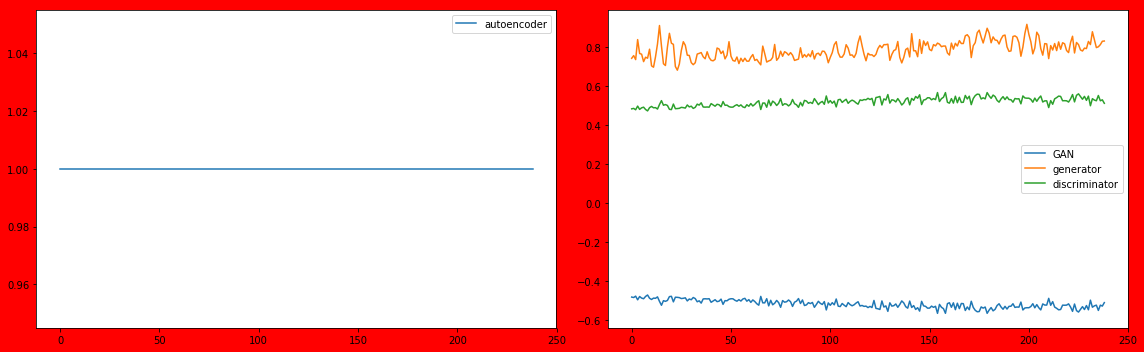

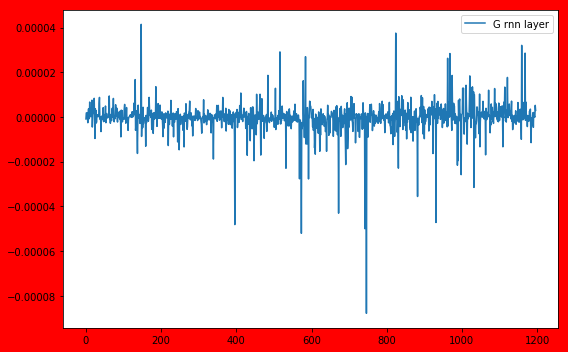

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 1]. loss: 35.016183 time: 434.3 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['generally speaking , please . yes , please . </s>']
true response:  nonsmoking , please . </s>
generate response:  ['no , thanks . by the way , what kind of backgrounds do you </s>']
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i want to buy a suit . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ["i ' m afraid i can ' t agree with you . i ' m sure </s>"]
true response:  you will need to pay late fees on these books . </s>
generate response:  ['i realize that . but i think i ’ m going to need some

[2 295] loss_ae: 1.000000 loss_g: 0.784075 loss_d_rel: 0.526707 time: 1.7 s
[2 300] loss_ae: 1.000000 loss_g: 0.794037 loss_d_rel: 0.531443 time: 1.7 s
[2 305] loss_ae: 1.000000 loss_g: 0.761924 loss_d_rel: 0.497991 time: 1.7 s
[2 310] loss_ae: 1.000000 loss_g: 0.803853 loss_d_rel: 0.512701 time: 1.7 s
[2 315] loss_ae: 1.000000 loss_g: 0.807749 loss_d_rel: 0.530946 time: 1.7 s
[2 320] loss_ae: 1.000000 loss_g: 0.747362 loss_d_rel: 0.492473 time: 1.6 s
[2 325] loss_ae: 1.000000 loss_g: 0.799353 loss_d_rel: 0.541518 time: 1.7 s
[2 330] loss_ae: 1.000000 loss_g: 0.771701 loss_d_rel: 0.519169 time: 1.7 s
[2 335] loss_ae: 1.000000 loss_g: 0.746877 loss_d_rel: 0.512326 time: 1.7 s
[2 340] loss_ae: 1.000000 loss_g: 0.772560 loss_d_rel: 0.531916 time: 1.7 s
[2 345] loss_ae: 1.000000 loss_g: 0.791664 loss_d_rel: 0.531454 time: 1.7 s
[2 350] loss_ae: 1.000000 loss_g: 0.838347 loss_d_rel: 0.532193 time: 1.7 s
[2 355] loss_ae: 1.000000 loss_g: 0.765884 loss_d_rel: 0.505358 time: 1.7 s
[2 360] loss

[2 835] loss_ae: 1.000000 loss_g: 0.875505 loss_d_rel: 0.530660 time: 1.7 s
[2 840] loss_ae: 1.000000 loss_g: 0.786639 loss_d_rel: 0.535836 time: 1.7 s
[2 845] loss_ae: 1.000000 loss_g: 0.780015 loss_d_rel: 0.532803 time: 1.7 s
[2 850] loss_ae: 1.000000 loss_g: 0.777742 loss_d_rel: 0.533120 time: 1.7 s
[2 855] loss_ae: 1.000000 loss_g: 0.796336 loss_d_rel: 0.495837 time: 1.7 s
[2 860] loss_ae: 1.000000 loss_g: 0.831690 loss_d_rel: 0.521201 time: 1.7 s
[2 865] loss_ae: 1.000000 loss_g: 0.821116 loss_d_rel: 0.536536 time: 1.7 s
[2 870] loss_ae: 1.000000 loss_g: 0.756559 loss_d_rel: 0.537876 time: 1.7 s
[2 875] loss_ae: 1.000000 loss_g: 0.775598 loss_d_rel: 0.537646 time: 1.7 s
[2 880] loss_ae: 1.000000 loss_g: 0.872008 loss_d_rel: 0.527770 time: 1.7 s
[2 885] loss_ae: 1.000000 loss_g: 0.877043 loss_d_rel: 0.559740 time: 1.7 s
[2 890] loss_ae: 1.000000 loss_g: 0.820851 loss_d_rel: 0.537202 time: 1.7 s
[2 895] loss_ae: 1.000000 loss_g: 0.789364 loss_d_rel: 0.547762 time: 1.7 s
[2 900] loss

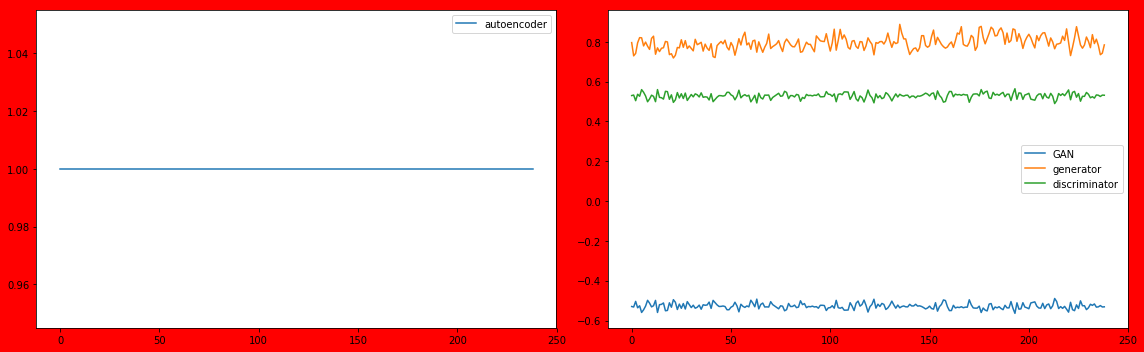

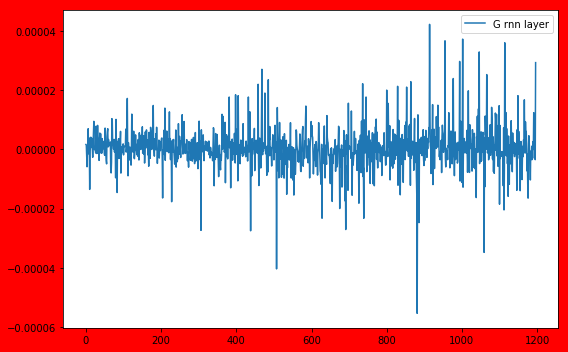

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 2]. loss: 34.053633 time: 408.8 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['generally speaking , may i ask you for a job ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ['no , thanks . by the way , what kind of backgrounds do you prefer ? </s>']
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i want to buy a suit of workmanship and maintained speakers . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ["i ' m going to the pub tonight , but i ' ve got a counterfeit </s>"]
true response:  you will need to pay late fees on these books . </s>
generate respo

[3 285] loss_ae: 1.000000 loss_g: 0.904742 loss_d_rel: 0.539524 time: 1.7 s
[3 290] loss_ae: 1.000000 loss_g: 0.855295 loss_d_rel: 0.507165 time: 1.7 s
[3 295] loss_ae: 1.000000 loss_g: 0.877782 loss_d_rel: 0.534398 time: 1.7 s
[3 300] loss_ae: 1.000000 loss_g: 0.806019 loss_d_rel: 0.526697 time: 1.7 s
[3 305] loss_ae: 1.000000 loss_g: 0.848868 loss_d_rel: 0.515696 time: 1.7 s
[3 310] loss_ae: 1.000000 loss_g: 0.851715 loss_d_rel: 0.524932 time: 1.7 s
[3 315] loss_ae: 1.000000 loss_g: 0.923249 loss_d_rel: 0.531141 time: 1.7 s
[3 320] loss_ae: 1.000000 loss_g: 0.876515 loss_d_rel: 0.521310 time: 1.7 s
[3 325] loss_ae: 1.000000 loss_g: 0.926417 loss_d_rel: 0.545495 time: 1.7 s
[3 330] loss_ae: 1.000000 loss_g: 0.804858 loss_d_rel: 0.502560 time: 1.7 s
[3 335] loss_ae: 1.000000 loss_g: 0.811231 loss_d_rel: 0.518653 time: 1.7 s
[3 340] loss_ae: 1.000000 loss_g: 0.861320 loss_d_rel: 0.567972 time: 1.7 s
[3 345] loss_ae: 1.000000 loss_g: 0.799087 loss_d_rel: 0.534719 time: 1.7 s
[3 350] loss

[3 825] loss_ae: 1.000000 loss_g: 0.916718 loss_d_rel: 0.550687 time: 1.7 s
[3 830] loss_ae: 1.000000 loss_g: 0.844234 loss_d_rel: 0.531584 time: 1.7 s
[3 835] loss_ae: 1.000000 loss_g: 0.767312 loss_d_rel: 0.529618 time: 1.7 s
[3 840] loss_ae: 1.000000 loss_g: 0.762133 loss_d_rel: 0.536397 time: 1.7 s
[3 845] loss_ae: 1.000000 loss_g: 0.765525 loss_d_rel: 0.509128 time: 1.6 s
[3 850] loss_ae: 1.000000 loss_g: 0.813990 loss_d_rel: 0.534437 time: 1.6 s
[3 855] loss_ae: 1.000000 loss_g: 0.819605 loss_d_rel: 0.531325 time: 1.7 s
[3 860] loss_ae: 1.000000 loss_g: 0.798535 loss_d_rel: 0.538403 time: 1.7 s
[3 865] loss_ae: 1.000000 loss_g: 0.775499 loss_d_rel: 0.538056 time: 1.7 s
[3 870] loss_ae: 1.000000 loss_g: 0.771622 loss_d_rel: 0.526208 time: 1.7 s
[3 875] loss_ae: 1.000000 loss_g: 0.785571 loss_d_rel: 0.531507 time: 1.7 s
[3 880] loss_ae: 1.000000 loss_g: 0.801025 loss_d_rel: 0.522960 time: 1.7 s
[3 885] loss_ae: 1.000000 loss_g: 0.826827 loss_d_rel: 0.521634 time: 1.7 s
[3 890] loss

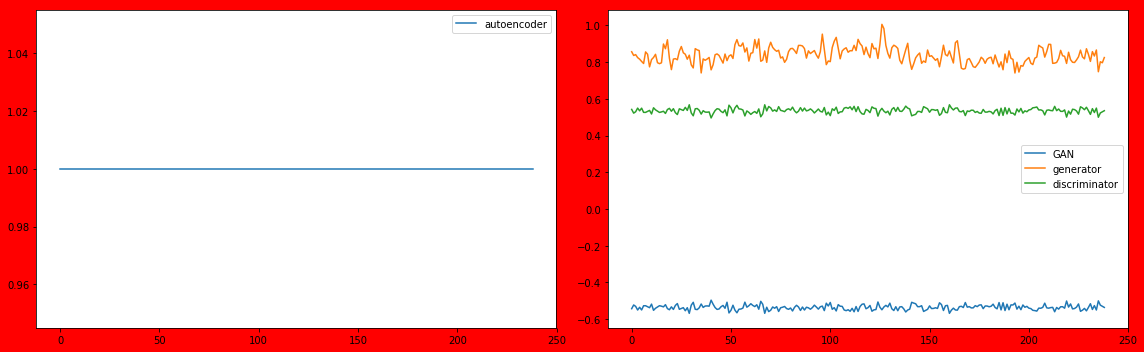

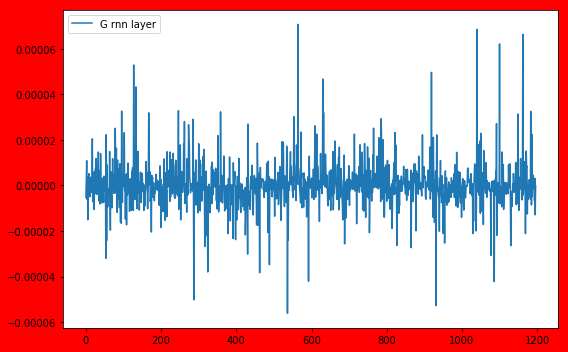

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 3]. loss: 36.149738 time: 406.2 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['hold on , please . yes , you are booked up at 9 : 00 pm </s>']
true response:  nonsmoking , please . </s>
generate response:  ['no , thanks . by the way , what kind of backgrounds do you prefer ? </s>']
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i want to go to the supermarket . what about tomorrow evening ? </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ["i ' m not sure if i could get my paycheck off . i can </s>"]
true response:  you will need to pay late fees on these books . </s>
generate re

[4 280] loss_ae: 1.000000 loss_g: 0.860334 loss_d_rel: 0.523831 time: 1.6 s
[4 285] loss_ae: 1.000000 loss_g: 0.900854 loss_d_rel: 0.525912 time: 1.7 s
[4 290] loss_ae: 1.000000 loss_g: 0.834872 loss_d_rel: 0.524107 time: 1.7 s
[4 295] loss_ae: 1.000000 loss_g: 0.820626 loss_d_rel: 0.521163 time: 1.7 s
[4 300] loss_ae: 1.000000 loss_g: 0.840912 loss_d_rel: 0.542528 time: 1.8 s
[4 305] loss_ae: 1.000000 loss_g: 0.822969 loss_d_rel: 0.534378 time: 1.7 s
[4 310] loss_ae: 1.000000 loss_g: 0.847713 loss_d_rel: 0.562996 time: 1.7 s
[4 315] loss_ae: 1.000000 loss_g: 0.812345 loss_d_rel: 0.529599 time: 1.7 s
[4 320] loss_ae: 1.000000 loss_g: 0.785668 loss_d_rel: 0.510865 time: 1.7 s
[4 325] loss_ae: 1.000000 loss_g: 0.843698 loss_d_rel: 0.545852 time: 1.8 s
[4 330] loss_ae: 1.000000 loss_g: 0.794653 loss_d_rel: 0.534746 time: 1.7 s
[4 335] loss_ae: 1.000000 loss_g: 0.808398 loss_d_rel: 0.521932 time: 1.7 s
[4 340] loss_ae: 1.000000 loss_g: 0.812609 loss_d_rel: 0.539666 time: 1.7 s
[4 345] loss

[4 820] loss_ae: 1.000000 loss_g: 0.805117 loss_d_rel: 0.504058 time: 1.6 s
[4 825] loss_ae: 1.000000 loss_g: 0.818948 loss_d_rel: 0.510649 time: 1.6 s
[4 830] loss_ae: 1.000000 loss_g: 0.877018 loss_d_rel: 0.541364 time: 1.7 s
[4 835] loss_ae: 1.000000 loss_g: 0.866286 loss_d_rel: 0.545863 time: 1.7 s
[4 840] loss_ae: 1.000000 loss_g: 0.785711 loss_d_rel: 0.537921 time: 1.6 s
[4 845] loss_ae: 1.000000 loss_g: 0.759904 loss_d_rel: 0.524712 time: 1.7 s
[4 850] loss_ae: 1.000000 loss_g: 0.817537 loss_d_rel: 0.520062 time: 1.7 s
[4 855] loss_ae: 1.000000 loss_g: 0.866883 loss_d_rel: 0.539098 time: 1.7 s
[4 860] loss_ae: 1.000000 loss_g: 0.818544 loss_d_rel: 0.531379 time: 1.7 s
[4 865] loss_ae: 1.000000 loss_g: 0.833771 loss_d_rel: 0.539932 time: 1.7 s
[4 870] loss_ae: 1.000000 loss_g: 0.762755 loss_d_rel: 0.523306 time: 1.6 s
[4 875] loss_ae: 1.000000 loss_g: 0.773655 loss_d_rel: 0.519802 time: 1.6 s
[4 880] loss_ae: 1.000000 loss_g: 0.850606 loss_d_rel: 0.539673 time: 1.7 s
[4 885] loss

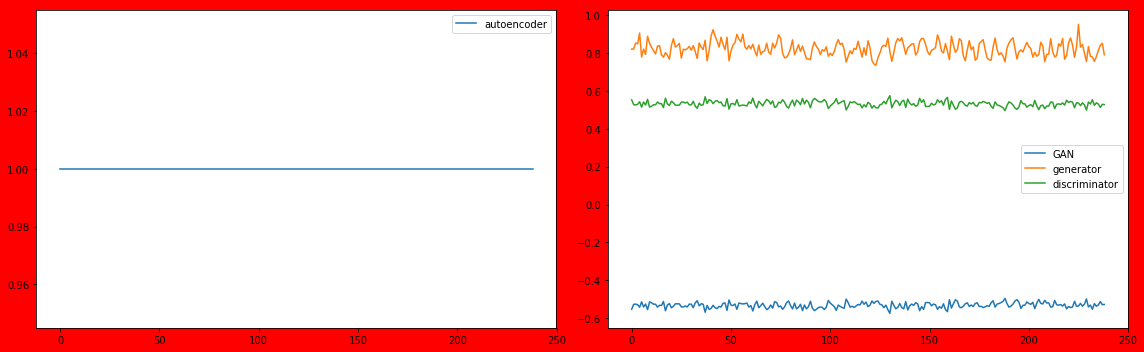

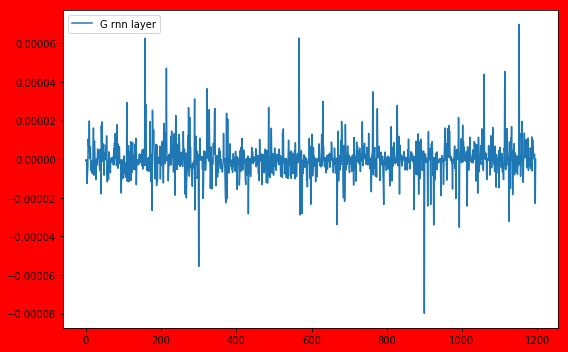

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 4]. loss: 36.519301 time: 404.6 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['hold on , please . yes , you are booked up at 9 : 00 pm tomorrow afternoon </s>']
true response:  nonsmoking , please . </s>
generate response:  ['one of my friends . </s>']
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i just want to go to the concert this evening . what do you think </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ['do you have any other questions ? </s>']
true response:  you will need to pay late fees on these books . </s>
generate response:  ['how do you choose your roommate ? </

[5 290] loss_ae: 1.000000 loss_g: 0.812998 loss_d_rel: 0.527020 time: 1.6 s
[5 295] loss_ae: 1.000000 loss_g: 0.842841 loss_d_rel: 0.540595 time: 1.6 s
[5 300] loss_ae: 1.000000 loss_g: 0.772931 loss_d_rel: 0.523638 time: 1.6 s
[5 305] loss_ae: 1.000000 loss_g: 0.771171 loss_d_rel: 0.520256 time: 1.6 s
[5 310] loss_ae: 1.000000 loss_g: 0.809035 loss_d_rel: 0.539329 time: 1.6 s
[5 315] loss_ae: 1.000000 loss_g: 0.802658 loss_d_rel: 0.521091 time: 1.6 s
[5 320] loss_ae: 1.000000 loss_g: 0.772558 loss_d_rel: 0.506167 time: 1.6 s
[5 325] loss_ae: 1.000000 loss_g: 0.828892 loss_d_rel: 0.529408 time: 1.6 s
[5 330] loss_ae: 1.000000 loss_g: 0.810050 loss_d_rel: 0.546056 time: 1.6 s
[5 335] loss_ae: 1.000000 loss_g: 0.815892 loss_d_rel: 0.543441 time: 1.6 s
[5 340] loss_ae: 1.000000 loss_g: 0.789865 loss_d_rel: 0.528488 time: 1.6 s
[5 345] loss_ae: 1.000000 loss_g: 0.834957 loss_d_rel: 0.545895 time: 1.6 s
[5 350] loss_ae: 1.000000 loss_g: 0.846774 loss_d_rel: 0.537262 time: 1.6 s
[5 355] loss

[5 830] loss_ae: 1.000000 loss_g: 0.846770 loss_d_rel: 0.547295 time: 1.6 s
[5 835] loss_ae: 1.000000 loss_g: 0.851284 loss_d_rel: 0.558036 time: 1.6 s
[5 840] loss_ae: 1.000000 loss_g: 0.799642 loss_d_rel: 0.516517 time: 1.6 s
[5 845] loss_ae: 1.000000 loss_g: 0.815938 loss_d_rel: 0.520533 time: 1.6 s
[5 850] loss_ae: 1.000000 loss_g: 0.828575 loss_d_rel: 0.528345 time: 1.6 s
[5 855] loss_ae: 1.000000 loss_g: 0.842466 loss_d_rel: 0.534455 time: 1.6 s
[5 860] loss_ae: 1.000000 loss_g: 0.835707 loss_d_rel: 0.540118 time: 1.6 s
[5 865] loss_ae: 1.000000 loss_g: 0.809676 loss_d_rel: 0.526133 time: 1.6 s
[5 870] loss_ae: 1.000000 loss_g: 0.798109 loss_d_rel: 0.524294 time: 1.6 s
[5 875] loss_ae: 1.000000 loss_g: 0.809921 loss_d_rel: 0.535976 time: 1.6 s
[5 880] loss_ae: 1.000000 loss_g: 0.844008 loss_d_rel: 0.528800 time: 1.6 s
[5 885] loss_ae: 1.000000 loss_g: 0.864943 loss_d_rel: 0.541324 time: 1.6 s
[5 890] loss_ae: 1.000000 loss_g: 0.810284 loss_d_rel: 0.520837 time: 1.6 s
[5 895] loss

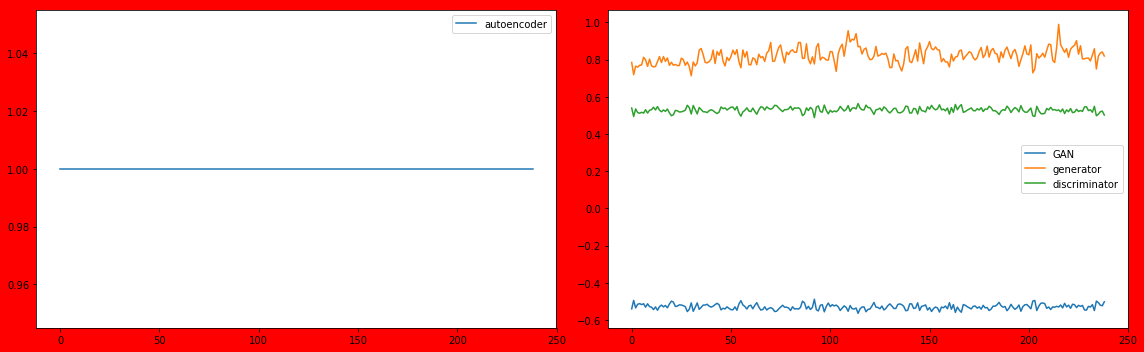

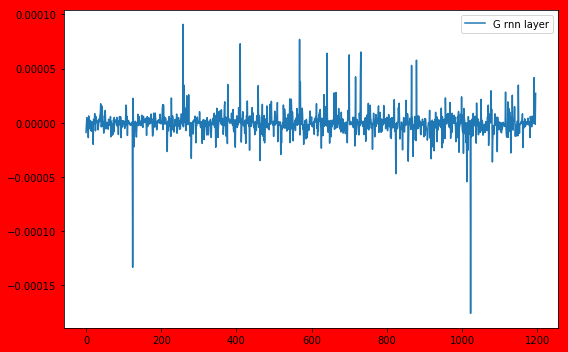

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 5]. loss: 50.487217 time: 378.4 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['hold on , please . yes , mr . emory . would you please repeat </s>']
true response:  nonsmoking , please . </s>
generate response:  ["no , i ' m not sure . but i think i ' ll have </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i just want to buy a new pair of jeans shoes . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ['do you have any other questions ? </s>']
true response:  you will need to pay late fees on these books . </s>
generate response:  ['what do you mean ? </s>']
true response:  

[6 300] loss_ae: 1.000000 loss_g: 0.908515 loss_d_rel: 0.528225 time: 1.6 s
[6 305] loss_ae: 1.000000 loss_g: 0.748023 loss_d_rel: 0.510610 time: 1.5 s
[6 310] loss_ae: 1.000000 loss_g: 0.801260 loss_d_rel: 0.536391 time: 1.6 s
[6 315] loss_ae: 1.000000 loss_g: 0.779562 loss_d_rel: 0.503134 time: 1.6 s
[6 320] loss_ae: 1.000000 loss_g: 0.831670 loss_d_rel: 0.531422 time: 1.6 s
[6 325] loss_ae: 1.000000 loss_g: 0.844077 loss_d_rel: 0.513899 time: 1.6 s
[6 330] loss_ae: 1.000000 loss_g: 0.883349 loss_d_rel: 0.532620 time: 1.6 s
[6 335] loss_ae: 1.000000 loss_g: 0.836634 loss_d_rel: 0.518042 time: 1.6 s
[6 340] loss_ae: 1.000000 loss_g: 0.773856 loss_d_rel: 0.505110 time: 1.6 s
[6 345] loss_ae: 1.000000 loss_g: 0.809028 loss_d_rel: 0.514244 time: 1.5 s
[6 350] loss_ae: 1.000000 loss_g: 0.889031 loss_d_rel: 0.543280 time: 1.6 s
[6 355] loss_ae: 1.000000 loss_g: 0.807448 loss_d_rel: 0.531732 time: 1.6 s
[6 360] loss_ae: 1.000000 loss_g: 0.830485 loss_d_rel: 0.525561 time: 1.6 s
[6 365] loss

[6 840] loss_ae: 1.000000 loss_g: 0.763638 loss_d_rel: 0.519140 time: 1.7 s
[6 845] loss_ae: 1.000000 loss_g: 0.792072 loss_d_rel: 0.521430 time: 1.7 s
[6 850] loss_ae: 1.000000 loss_g: 0.808340 loss_d_rel: 0.515232 time: 1.7 s
[6 855] loss_ae: 1.000000 loss_g: 0.833377 loss_d_rel: 0.511197 time: 1.6 s
[6 860] loss_ae: 1.000000 loss_g: 0.831073 loss_d_rel: 0.523047 time: 1.6 s
[6 865] loss_ae: 1.000000 loss_g: 0.843488 loss_d_rel: 0.537535 time: 1.6 s
[6 870] loss_ae: 1.000000 loss_g: 0.824843 loss_d_rel: 0.526686 time: 1.6 s
[6 875] loss_ae: 1.000000 loss_g: 0.745288 loss_d_rel: 0.509019 time: 1.6 s
[6 880] loss_ae: 1.000000 loss_g: 0.804890 loss_d_rel: 0.511154 time: 1.7 s
[6 885] loss_ae: 1.000000 loss_g: 0.765642 loss_d_rel: 0.517922 time: 1.7 s
[6 890] loss_ae: 1.000000 loss_g: 0.755032 loss_d_rel: 0.507422 time: 1.7 s
[6 895] loss_ae: 1.000000 loss_g: 0.850341 loss_d_rel: 0.530433 time: 1.8 s
[6 900] loss_ae: 1.000000 loss_g: 0.862388 loss_d_rel: 0.525574 time: 1.7 s
[6 905] loss

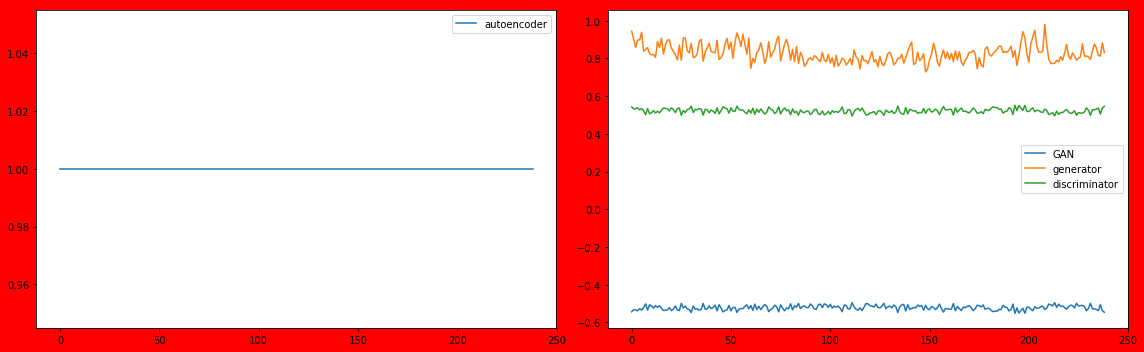

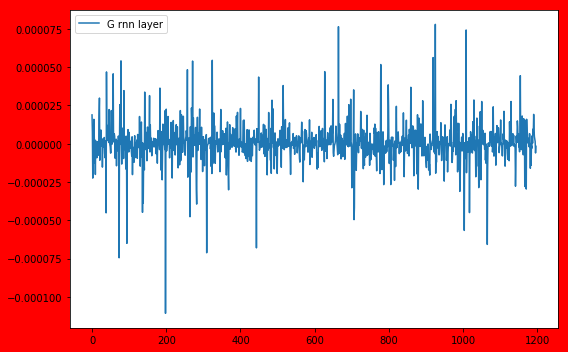

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 6]. loss: 42.960322 time: 392.1 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['generally speaking , may i ask you some questions ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ["no , i ' m not sure . but i like its color . it ' s </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i just want to buy a new pair of jeans shoes . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ['what do you mean ? </s>']
true response:  you will need to pay late fees on these books . </s>
generate response:  ['what do you mean ? </s>']
true response:  that sounds nice . 

[7 300] loss_ae: 1.000000 loss_g: 0.838082 loss_d_rel: 0.530367 time: 1.8 s
[7 305] loss_ae: 1.000000 loss_g: 0.917141 loss_d_rel: 0.533783 time: 1.7 s
[7 310] loss_ae: 1.000000 loss_g: 0.934262 loss_d_rel: 0.520475 time: 1.7 s
[7 315] loss_ae: 1.000000 loss_g: 0.872196 loss_d_rel: 0.529864 time: 1.8 s
[7 320] loss_ae: 1.000000 loss_g: 0.799533 loss_d_rel: 0.525782 time: 1.7 s
[7 325] loss_ae: 1.000000 loss_g: 0.767784 loss_d_rel: 0.512279 time: 1.7 s
[7 330] loss_ae: 1.000000 loss_g: 0.791812 loss_d_rel: 0.535870 time: 1.7 s
[7 335] loss_ae: 1.000000 loss_g: 0.864945 loss_d_rel: 0.531557 time: 1.8 s
[7 340] loss_ae: 1.000000 loss_g: 0.821608 loss_d_rel: 0.517682 time: 1.7 s
[7 345] loss_ae: 1.000000 loss_g: 0.791896 loss_d_rel: 0.508854 time: 1.8 s
[7 350] loss_ae: 1.000000 loss_g: 0.843931 loss_d_rel: 0.506187 time: 1.7 s
[7 355] loss_ae: 1.000000 loss_g: 0.877458 loss_d_rel: 0.524659 time: 1.8 s
[7 360] loss_ae: 1.000000 loss_g: 0.830057 loss_d_rel: 0.527976 time: 1.7 s
[7 365] loss

[7 840] loss_ae: 1.000000 loss_g: 0.810854 loss_d_rel: 0.511828 time: 1.8 s
[7 845] loss_ae: 1.000000 loss_g: 0.855388 loss_d_rel: 0.523708 time: 1.8 s
[7 850] loss_ae: 1.000000 loss_g: 0.836206 loss_d_rel: 0.505195 time: 1.8 s
[7 855] loss_ae: 1.000000 loss_g: 0.893751 loss_d_rel: 0.528908 time: 1.7 s
[7 860] loss_ae: 1.000000 loss_g: 0.815291 loss_d_rel: 0.505237 time: 1.7 s
[7 865] loss_ae: 1.000000 loss_g: 0.780735 loss_d_rel: 0.520733 time: 1.7 s
[7 870] loss_ae: 1.000000 loss_g: 0.852441 loss_d_rel: 0.522080 time: 1.8 s
[7 875] loss_ae: 1.000000 loss_g: 0.837734 loss_d_rel: 0.531883 time: 1.8 s
[7 880] loss_ae: 1.000000 loss_g: 0.852537 loss_d_rel: 0.544074 time: 1.8 s
[7 885] loss_ae: 1.000000 loss_g: 0.787939 loss_d_rel: 0.515354 time: 1.7 s
[7 890] loss_ae: 1.000000 loss_g: 0.828606 loss_d_rel: 0.528012 time: 1.8 s
[7 895] loss_ae: 1.000000 loss_g: 0.940452 loss_d_rel: 0.546216 time: 1.8 s
[7 900] loss_ae: 1.000000 loss_g: 0.850215 loss_d_rel: 0.514260 time: 1.7 s
[7 905] loss

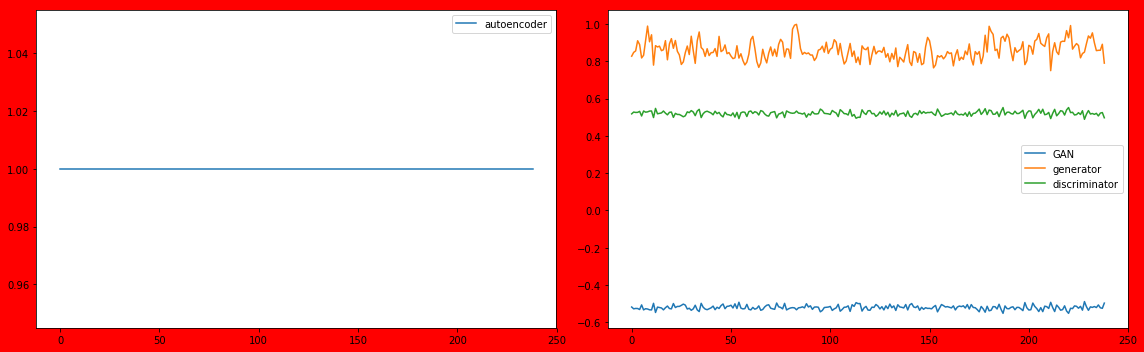

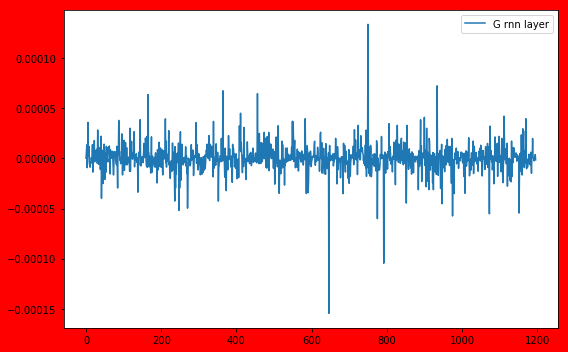

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 7]. loss: 57.126833 time: 424.9 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['hold on , ted . you may have seen your samples . you </s>']
true response:  nonsmoking , please . </s>
generate response:  ["no , i ' m not sure . thank you very much . </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['what do you think of linen ? </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ['what do you mean ? </s>']
true response:  you will need to pay late fees on these books . </s>
generate response:  ['what do you mean ? </s>']
true response:  that sounds nice . </s>
generate response:  

[8 305] loss_ae: 1.000000 loss_g: 0.755920 loss_d_rel: 0.508491 time: 1.8 s
[8 310] loss_ae: 1.000000 loss_g: 0.862757 loss_d_rel: 0.511566 time: 1.8 s
[8 315] loss_ae: 1.000000 loss_g: 0.903483 loss_d_rel: 0.501292 time: 1.7 s
[8 320] loss_ae: 1.000000 loss_g: 1.101786 loss_d_rel: 0.526565 time: 1.8 s
[8 325] loss_ae: 1.000000 loss_g: 0.925419 loss_d_rel: 0.510844 time: 1.7 s
[8 330] loss_ae: 1.000000 loss_g: 0.797464 loss_d_rel: 0.519267 time: 1.7 s
[8 335] loss_ae: 1.000000 loss_g: 0.887765 loss_d_rel: 0.520600 time: 1.7 s
[8 340] loss_ae: 1.000000 loss_g: 0.803072 loss_d_rel: 0.520640 time: 1.7 s
[8 345] loss_ae: 1.000000 loss_g: 0.877399 loss_d_rel: 0.508825 time: 1.7 s
[8 350] loss_ae: 1.000000 loss_g: 0.857385 loss_d_rel: 0.521174 time: 1.7 s
[8 355] loss_ae: 1.000000 loss_g: 0.878104 loss_d_rel: 0.508524 time: 1.7 s
[8 360] loss_ae: 1.000000 loss_g: 0.888445 loss_d_rel: 0.547094 time: 1.8 s
[8 365] loss_ae: 1.000000 loss_g: 0.823555 loss_d_rel: 0.508265 time: 1.8 s
[8 370] loss

[8 845] loss_ae: 1.000000 loss_g: 0.799696 loss_d_rel: 0.508266 time: 1.8 s
[8 850] loss_ae: 1.000000 loss_g: 0.814749 loss_d_rel: 0.530476 time: 1.8 s
[8 855] loss_ae: 1.000000 loss_g: 0.857014 loss_d_rel: 0.514060 time: 1.7 s
[8 860] loss_ae: 1.000000 loss_g: 0.907825 loss_d_rel: 0.533349 time: 1.8 s
[8 865] loss_ae: 1.000000 loss_g: 0.856261 loss_d_rel: 0.521935 time: 1.7 s
[8 870] loss_ae: 1.000000 loss_g: 0.807804 loss_d_rel: 0.506640 time: 1.8 s
[8 875] loss_ae: 1.000000 loss_g: 0.912055 loss_d_rel: 0.529935 time: 1.8 s
[8 880] loss_ae: 1.000000 loss_g: 0.819306 loss_d_rel: 0.509341 time: 1.8 s
[8 885] loss_ae: 1.000000 loss_g: 0.810038 loss_d_rel: 0.528433 time: 1.8 s
[8 890] loss_ae: 1.000000 loss_g: 0.758487 loss_d_rel: 0.481095 time: 1.7 s
[8 895] loss_ae: 1.000000 loss_g: 0.896828 loss_d_rel: 0.505154 time: 1.9 s
[8 900] loss_ae: 1.000000 loss_g: 0.965019 loss_d_rel: 0.522493 time: 1.8 s
[8 905] loss_ae: 1.000000 loss_g: 0.889783 loss_d_rel: 0.538299 time: 1.9 s
[8 910] loss

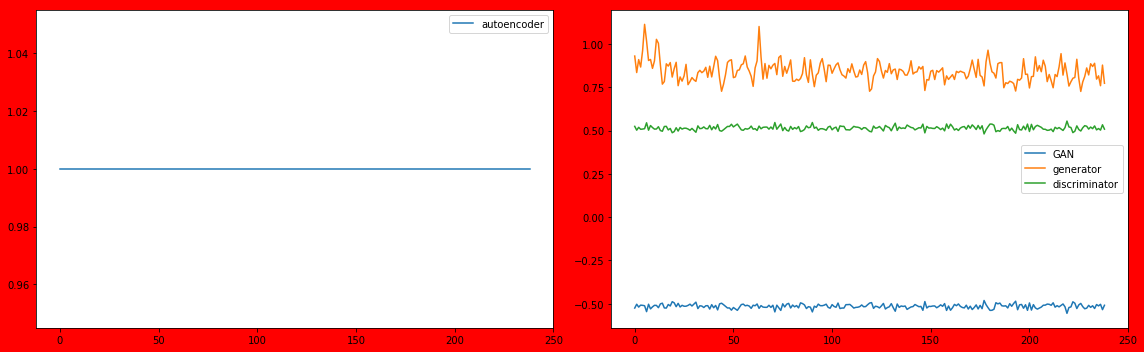

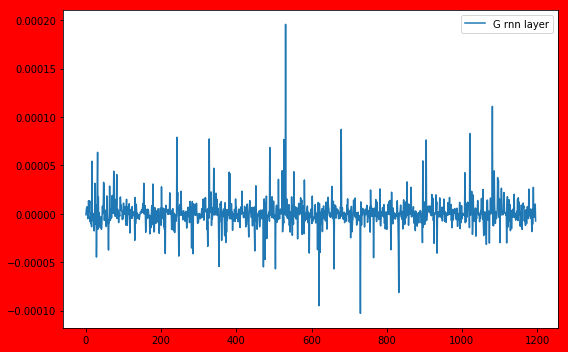

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 8]. loss: 48.778906 time: 424.0 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['generally speaking , may i ask you some questions ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ["no , i ' m not sure . thank you very much . </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i want to buy a new pair of jeans shoes . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ['what do you mean ? </s>']
true response:  you will need to pay late fees on these books . </s>
generate response:  ['what do you mean ? </s>']
true response:  that sounds nice . </s>
generate

[9 300] loss_ae: 1.000000 loss_g: 0.794427 loss_d_rel: 0.513638 time: 1.8 s
[9 305] loss_ae: 1.000000 loss_g: 0.785729 loss_d_rel: 0.506391 time: 1.8 s
[9 310] loss_ae: 1.000000 loss_g: 0.836412 loss_d_rel: 0.540156 time: 1.9 s
[9 315] loss_ae: 1.000000 loss_g: 0.894597 loss_d_rel: 0.515011 time: 1.8 s
[9 320] loss_ae: 1.000000 loss_g: 0.873692 loss_d_rel: 0.508909 time: 1.8 s
[9 325] loss_ae: 1.000000 loss_g: 0.963331 loss_d_rel: 0.506815 time: 1.8 s
[9 330] loss_ae: 1.000000 loss_g: 0.893422 loss_d_rel: 0.525102 time: 1.8 s
[9 335] loss_ae: 1.000000 loss_g: 0.766192 loss_d_rel: 0.495745 time: 1.8 s
[9 340] loss_ae: 1.000000 loss_g: 0.845811 loss_d_rel: 0.522247 time: 1.8 s
[9 345] loss_ae: 1.000000 loss_g: 0.926633 loss_d_rel: 0.512557 time: 1.8 s
[9 350] loss_ae: 1.000000 loss_g: 0.839437 loss_d_rel: 0.518962 time: 1.9 s
[9 355] loss_ae: 1.000000 loss_g: 0.901464 loss_d_rel: 0.508214 time: 1.8 s
[9 360] loss_ae: 1.000000 loss_g: 0.778457 loss_d_rel: 0.500420 time: 1.9 s
[9 365] loss

[9 840] loss_ae: 1.000000 loss_g: 0.898385 loss_d_rel: 0.495439 time: 1.8 s
[9 845] loss_ae: 1.000000 loss_g: 0.861393 loss_d_rel: 0.492521 time: 1.7 s
[9 850] loss_ae: 1.000000 loss_g: 0.897534 loss_d_rel: 0.495731 time: 1.8 s
[9 855] loss_ae: 1.000000 loss_g: 0.838816 loss_d_rel: 0.506192 time: 1.7 s
[9 860] loss_ae: 1.000000 loss_g: 0.919768 loss_d_rel: 0.505456 time: 1.8 s
[9 865] loss_ae: 1.000000 loss_g: 0.878284 loss_d_rel: 0.514587 time: 1.8 s
[9 870] loss_ae: 1.000000 loss_g: 0.989542 loss_d_rel: 0.507288 time: 1.8 s
[9 875] loss_ae: 1.000000 loss_g: 0.936245 loss_d_rel: 0.507586 time: 1.7 s
[9 880] loss_ae: 1.000000 loss_g: 0.874106 loss_d_rel: 0.491228 time: 1.7 s
[9 885] loss_ae: 1.000000 loss_g: 0.946352 loss_d_rel: 0.535561 time: 1.8 s
[9 890] loss_ae: 1.000000 loss_g: 0.837827 loss_d_rel: 0.507519 time: 1.7 s
[9 895] loss_ae: 1.000000 loss_g: 0.837529 loss_d_rel: 0.506722 time: 1.7 s
[9 900] loss_ae: 1.000000 loss_g: 0.813238 loss_d_rel: 0.508721 time: 1.7 s
[9 905] loss

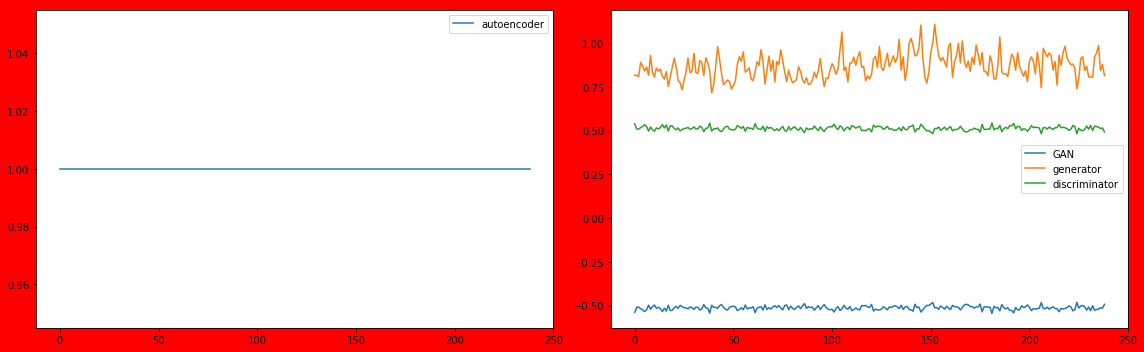

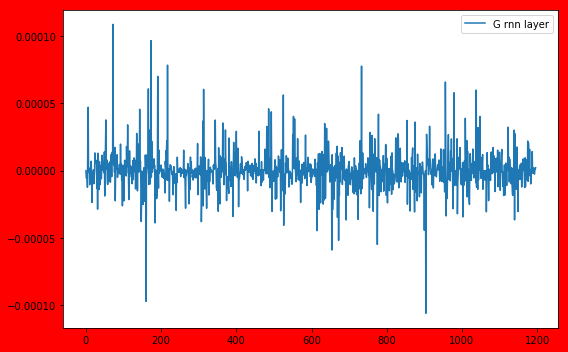

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 9]. loss: 60.326267 time: 423.8 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['hold on , paula . you may have a 3 - balanced </s>']
true response:  nonsmoking , please . </s>
generate response:  ["no , i don ' t think i ' m going to quit my </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i ’ d like to try my best . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ['what do you mean by cautious ? </s>']
true response:  you will need to pay late fees on these books . </s>
generate response:  ['what do you mean ? </s>']
true response:  that sounds nice . </s>
generate respons

[10 305] loss_ae: 1.000000 loss_g: 0.762674 loss_d_rel: 0.489467 time: 1.7 s
[10 310] loss_ae: 1.000000 loss_g: 0.898422 loss_d_rel: 0.525321 time: 1.8 s
[10 315] loss_ae: 1.000000 loss_g: 0.844073 loss_d_rel: 0.511490 time: 1.8 s
[10 320] loss_ae: 1.000000 loss_g: 0.888221 loss_d_rel: 0.511289 time: 1.8 s
[10 325] loss_ae: 1.000000 loss_g: 0.959672 loss_d_rel: 0.514150 time: 1.8 s
[10 330] loss_ae: 1.000000 loss_g: 0.888572 loss_d_rel: 0.525149 time: 1.7 s
[10 335] loss_ae: 1.000000 loss_g: 0.852806 loss_d_rel: 0.496917 time: 1.8 s
[10 340] loss_ae: 1.000000 loss_g: 0.854155 loss_d_rel: 0.499035 time: 1.7 s
[10 345] loss_ae: 1.000000 loss_g: 0.877083 loss_d_rel: 0.496032 time: 1.7 s
[10 350] loss_ae: 1.000000 loss_g: 0.988305 loss_d_rel: 0.532637 time: 1.8 s
[10 355] loss_ae: 1.000000 loss_g: 0.855786 loss_d_rel: 0.516422 time: 1.8 s
[10 360] loss_ae: 1.000000 loss_g: 0.799238 loss_d_rel: 0.514459 time: 1.7 s
[10 365] loss_ae: 1.000000 loss_g: 0.842945 loss_d_rel: 0.536612 time: 1.8 s

[10 840] loss_ae: 1.000000 loss_g: 0.911610 loss_d_rel: 0.514547 time: 1.7 s
[10 845] loss_ae: 1.000000 loss_g: 0.831446 loss_d_rel: 0.495958 time: 1.7 s
[10 850] loss_ae: 1.000000 loss_g: 0.927869 loss_d_rel: 0.507466 time: 1.8 s
[10 855] loss_ae: 1.000000 loss_g: 0.908822 loss_d_rel: 0.505551 time: 1.8 s
[10 860] loss_ae: 1.000000 loss_g: 1.037434 loss_d_rel: 0.523971 time: 1.7 s
[10 865] loss_ae: 1.000000 loss_g: 0.859139 loss_d_rel: 0.512803 time: 1.7 s
[10 870] loss_ae: 1.000000 loss_g: 0.917377 loss_d_rel: 0.525911 time: 1.8 s
[10 875] loss_ae: 1.000000 loss_g: 0.970407 loss_d_rel: 0.546015 time: 1.8 s
[10 880] loss_ae: 1.000000 loss_g: 0.994962 loss_d_rel: 0.521156 time: 1.8 s
[10 885] loss_ae: 1.000000 loss_g: 1.005320 loss_d_rel: 0.518317 time: 1.7 s
[10 890] loss_ae: 1.000000 loss_g: 0.970878 loss_d_rel: 0.528626 time: 1.8 s
[10 895] loss_ae: 1.000000 loss_g: 0.862324 loss_d_rel: 0.493957 time: 1.7 s
[10 900] loss_ae: 1.000000 loss_g: 0.872125 loss_d_rel: 0.497222 time: 1.8 s

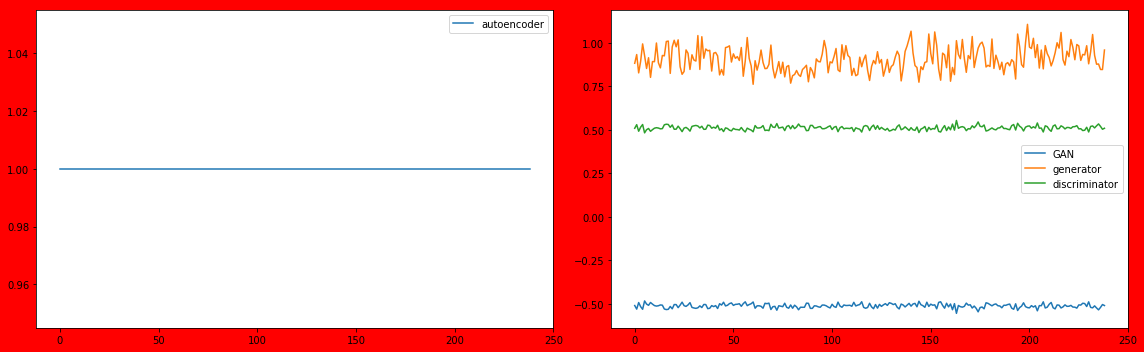

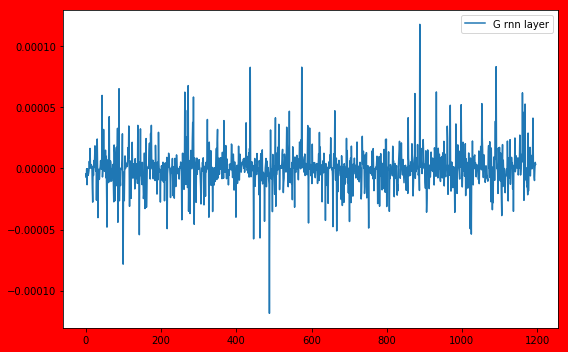

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 10]. loss: 60.351732 time: 424.9 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['generally speaking , may i ask you some questions ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ["no , i don ' t mind . i am sure that she has a </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['what do you recommend ? </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ['what do you mean by cautious ? what sectors do you prefer ? </s>']
true response:  you will need to pay late fees on these books . </s>
generate response:  ['what do you mean ? </s>']
true response:  that 

[11 300] loss_ae: 1.000000 loss_g: 0.901914 loss_d_rel: 0.512554 time: 2.1 s
[11 305] loss_ae: 1.000000 loss_g: 0.843422 loss_d_rel: 0.511528 time: 2.2 s
[11 310] loss_ae: 1.000000 loss_g: 0.955501 loss_d_rel: 0.497153 time: 2.1 s
[11 315] loss_ae: 1.000000 loss_g: 0.880030 loss_d_rel: 0.510465 time: 2.1 s
[11 320] loss_ae: 1.000000 loss_g: 0.939442 loss_d_rel: 0.514897 time: 2.1 s
[11 325] loss_ae: 1.000000 loss_g: 1.016328 loss_d_rel: 0.500297 time: 2.1 s
[11 330] loss_ae: 1.000000 loss_g: 0.848269 loss_d_rel: 0.510548 time: 2.1 s
[11 335] loss_ae: 1.000000 loss_g: 0.898064 loss_d_rel: 0.503801 time: 2.1 s
[11 340] loss_ae: 1.000000 loss_g: 0.848919 loss_d_rel: 0.491881 time: 2.1 s
[11 345] loss_ae: 1.000000 loss_g: 0.929257 loss_d_rel: 0.517522 time: 2.1 s
[11 350] loss_ae: 1.000000 loss_g: 0.873593 loss_d_rel: 0.505794 time: 2.0 s
[11 355] loss_ae: 1.000000 loss_g: 0.815928 loss_d_rel: 0.498148 time: 2.0 s
[11 360] loss_ae: 1.000000 loss_g: 0.817444 loss_d_rel: 0.503680 time: 2.1 s

[11 835] loss_ae: 1.000000 loss_g: 0.894188 loss_d_rel: 0.505853 time: 1.7 s
[11 840] loss_ae: 1.000000 loss_g: 0.911997 loss_d_rel: 0.506274 time: 1.7 s
[11 845] loss_ae: 1.000000 loss_g: 0.988902 loss_d_rel: 0.514850 time: 1.7 s
[11 850] loss_ae: 1.000000 loss_g: 0.857694 loss_d_rel: 0.503655 time: 1.7 s
[11 855] loss_ae: 1.000000 loss_g: 0.913789 loss_d_rel: 0.518247 time: 1.7 s
[11 860] loss_ae: 1.000000 loss_g: 0.905245 loss_d_rel: 0.528624 time: 1.7 s
[11 865] loss_ae: 1.000000 loss_g: 0.925149 loss_d_rel: 0.497306 time: 1.7 s
[11 870] loss_ae: 1.000000 loss_g: 1.026178 loss_d_rel: 0.491328 time: 1.7 s
[11 875] loss_ae: 1.000000 loss_g: 1.002347 loss_d_rel: 0.511605 time: 1.7 s
[11 880] loss_ae: 1.000000 loss_g: 1.045668 loss_d_rel: 0.519752 time: 1.7 s
[11 885] loss_ae: 1.000000 loss_g: 0.788424 loss_d_rel: 0.491254 time: 1.7 s
[11 890] loss_ae: 1.000000 loss_g: 0.918099 loss_d_rel: 0.502616 time: 1.7 s
[11 895] loss_ae: 1.000000 loss_g: 0.879344 loss_d_rel: 0.514377 time: 1.7 s

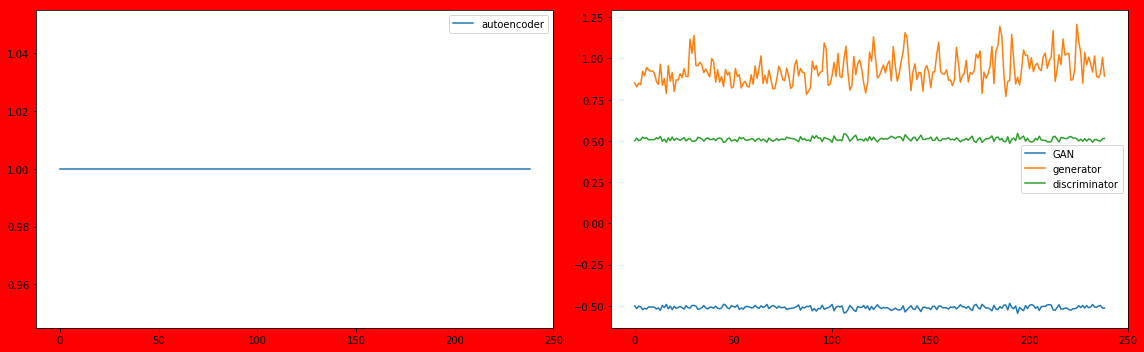

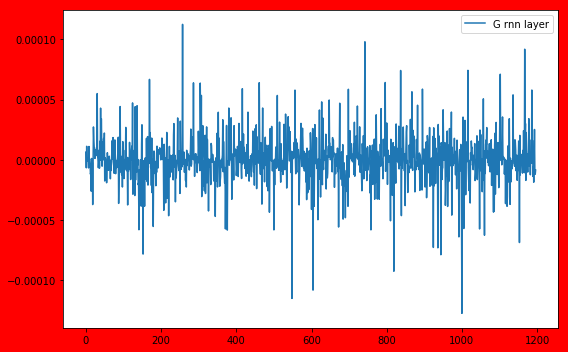

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 11]. loss: 70.397594 time: 456.2 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['generally speaking , may i ask her ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ['no , i am afraid not . i am sure that she has a girlfriend . </s>']
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i ’ d like to try my best . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ['what do you mean by cautious ? </s>']
true response:  you will need to pay late fees on these books . </s>
generate response:  ['what do you mean ? </s>']
true response:  that sounds nice . </s>
generat

[12 310] loss_ae: 1.000000 loss_g: 0.875798 loss_d_rel: 0.507588 time: 1.7 s
[12 315] loss_ae: 1.000000 loss_g: 0.811656 loss_d_rel: 0.483026 time: 1.6 s
[12 320] loss_ae: 1.000000 loss_g: 0.958060 loss_d_rel: 0.525184 time: 1.7 s
[12 325] loss_ae: 1.000000 loss_g: 0.890956 loss_d_rel: 0.509816 time: 1.7 s
[12 330] loss_ae: 1.000000 loss_g: 0.746398 loss_d_rel: 0.497285 time: 1.7 s
[12 335] loss_ae: 1.000000 loss_g: 0.803980 loss_d_rel: 0.489065 time: 1.7 s
[12 340] loss_ae: 1.000000 loss_g: 0.891007 loss_d_rel: 0.521826 time: 1.7 s
[12 345] loss_ae: 1.000000 loss_g: 0.870383 loss_d_rel: 0.490133 time: 1.7 s
[12 350] loss_ae: 1.000000 loss_g: 0.845990 loss_d_rel: 0.497914 time: 1.7 s
[12 355] loss_ae: 1.000000 loss_g: 0.857651 loss_d_rel: 0.501422 time: 1.7 s
[12 360] loss_ae: 1.000000 loss_g: 0.799220 loss_d_rel: 0.515722 time: 1.7 s
[12 365] loss_ae: 1.000000 loss_g: 0.757978 loss_d_rel: 0.492114 time: 1.7 s
[12 370] loss_ae: 1.000000 loss_g: 0.801414 loss_d_rel: 0.483465 time: 1.7 s

[12 845] loss_ae: 1.000000 loss_g: 0.832991 loss_d_rel: 0.506659 time: 1.8 s
[12 850] loss_ae: 1.000000 loss_g: 0.854460 loss_d_rel: 0.503253 time: 1.9 s
[12 855] loss_ae: 1.000000 loss_g: 0.802999 loss_d_rel: 0.490003 time: 1.8 s
[12 860] loss_ae: 1.000000 loss_g: 0.813810 loss_d_rel: 0.516985 time: 1.8 s
[12 865] loss_ae: 1.000000 loss_g: 0.862794 loss_d_rel: 0.504028 time: 1.8 s
[12 870] loss_ae: 1.000000 loss_g: 0.886612 loss_d_rel: 0.492564 time: 1.8 s
[12 875] loss_ae: 1.000000 loss_g: 0.859730 loss_d_rel: 0.512039 time: 1.8 s
[12 880] loss_ae: 1.000000 loss_g: 0.923171 loss_d_rel: 0.497539 time: 1.9 s
[12 885] loss_ae: 1.000000 loss_g: 0.899217 loss_d_rel: 0.489658 time: 1.9 s
[12 890] loss_ae: 1.000000 loss_g: 1.020376 loss_d_rel: 0.502957 time: 1.9 s
[12 895] loss_ae: 1.000000 loss_g: 0.982477 loss_d_rel: 0.507619 time: 1.9 s
[12 900] loss_ae: 1.000000 loss_g: 0.851691 loss_d_rel: 0.495097 time: 1.8 s
[12 905] loss_ae: 1.000000 loss_g: 0.856483 loss_d_rel: 0.507423 time: 1.8 s

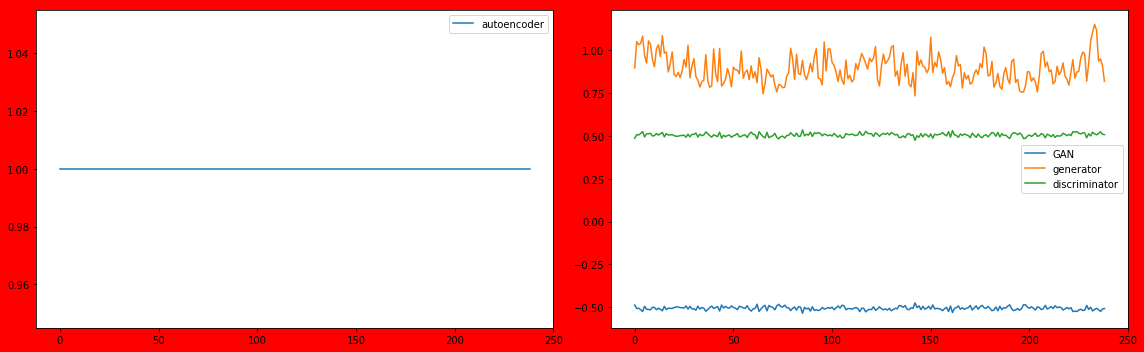

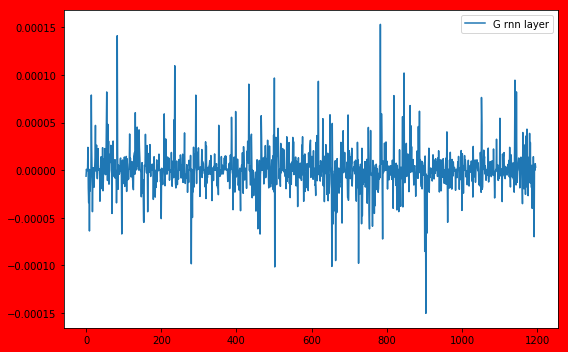

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 12]. loss: 67.646205 time: 420.3 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['hold a letter of recommendation agenda for you , stu , and <unk> </s>']
true response:  nonsmoking , please . </s>
generate response:  ["no , i ' m not sure . </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['what do you want ? </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ['what do you mean by cautious ? </s>']
true response:  you will need to pay late fees on these books . </s>
generate response:  ['what do you mean by cautious ? </s>']
true response:  that sounds nice . </s>
generate respon

[13 310] loss_ae: 1.000000 loss_g: 0.863895 loss_d_rel: 0.492398 time: 1.8 s
[13 315] loss_ae: 1.000000 loss_g: 0.821710 loss_d_rel: 0.500128 time: 1.8 s
[13 320] loss_ae: 1.000000 loss_g: 0.828881 loss_d_rel: 0.501408 time: 1.8 s
[13 325] loss_ae: 1.000000 loss_g: 0.739679 loss_d_rel: 0.483630 time: 1.8 s
[13 330] loss_ae: 1.000000 loss_g: 0.821282 loss_d_rel: 0.517380 time: 1.9 s
[13 335] loss_ae: 1.000000 loss_g: 0.805898 loss_d_rel: 0.507022 time: 1.8 s
[13 340] loss_ae: 1.000000 loss_g: 0.985714 loss_d_rel: 0.501587 time: 1.9 s
[13 345] loss_ae: 1.000000 loss_g: 0.900725 loss_d_rel: 0.495926 time: 1.8 s
[13 350] loss_ae: 1.000000 loss_g: 0.894244 loss_d_rel: 0.498251 time: 1.8 s
[13 355] loss_ae: 1.000000 loss_g: 0.835148 loss_d_rel: 0.497877 time: 1.8 s
[13 360] loss_ae: 1.000000 loss_g: 0.845991 loss_d_rel: 0.493279 time: 1.8 s
[13 365] loss_ae: 1.000000 loss_g: 0.859117 loss_d_rel: 0.488200 time: 1.9 s
[13 370] loss_ae: 1.000000 loss_g: 0.873474 loss_d_rel: 0.502655 time: 1.8 s

[13 845] loss_ae: 1.000000 loss_g: 0.885658 loss_d_rel: 0.489242 time: 1.8 s
[13 850] loss_ae: 1.000000 loss_g: 0.870658 loss_d_rel: 0.492637 time: 1.8 s
[13 855] loss_ae: 1.000000 loss_g: 0.825846 loss_d_rel: 0.497431 time: 1.8 s
[13 860] loss_ae: 1.000000 loss_g: 0.774994 loss_d_rel: 0.499423 time: 1.8 s
[13 865] loss_ae: 1.000000 loss_g: 0.836243 loss_d_rel: 0.516558 time: 1.8 s
[13 870] loss_ae: 1.000000 loss_g: 0.863458 loss_d_rel: 0.502960 time: 1.8 s
[13 875] loss_ae: 1.000000 loss_g: 0.885259 loss_d_rel: 0.495898 time: 1.9 s
[13 880] loss_ae: 1.000000 loss_g: 0.878993 loss_d_rel: 0.492242 time: 1.8 s
[13 885] loss_ae: 1.000000 loss_g: 0.813099 loss_d_rel: 0.486677 time: 1.8 s
[13 890] loss_ae: 1.000000 loss_g: 0.853624 loss_d_rel: 0.494321 time: 1.9 s
[13 895] loss_ae: 1.000000 loss_g: 0.878175 loss_d_rel: 0.525259 time: 1.8 s
[13 900] loss_ae: 1.000000 loss_g: 0.791608 loss_d_rel: 0.501762 time: 1.8 s
[13 905] loss_ae: 1.000000 loss_g: 0.809835 loss_d_rel: 0.500454 time: 1.8 s

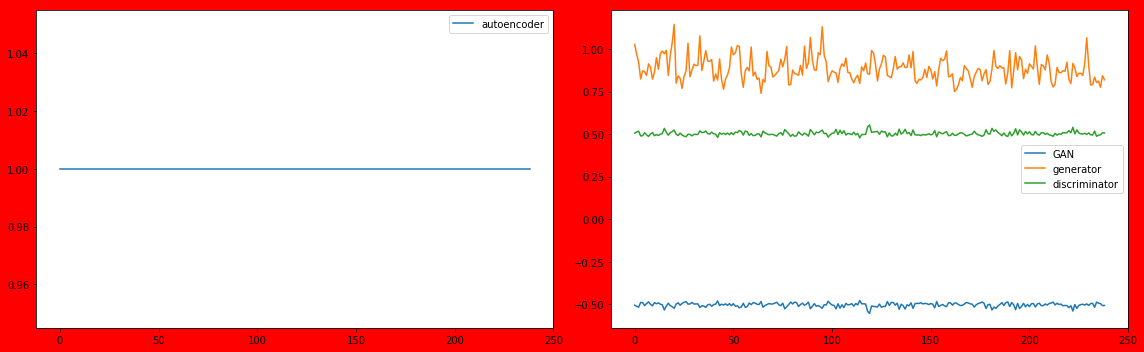

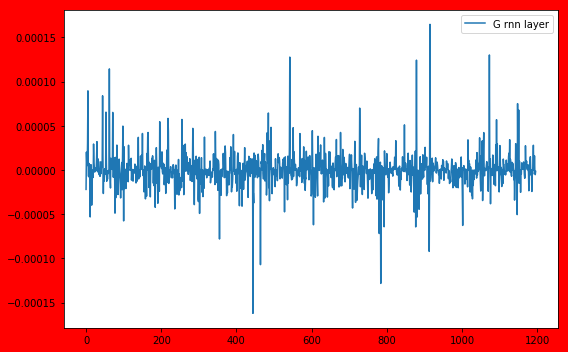

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 13]. loss: 60.506418 time: 436.9 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['hold a letter of recommendation , please . </s>']
true response:  nonsmoking , please . </s>
generate response:  ["<unk> . i ' m afraid not . </s>"]
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['what do you choose ? </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ["what ' s the problem ? </s>"]
true response:  you will need to pay late fees on these books . </s>
generate response:  ['what do you mean by cautious ? </s>']
true response:  that sounds nice . </s>
generate response:  ["<unk> . i ' m no

[14 315] loss_ae: 1.000000 loss_g: 0.753231 loss_d_rel: 0.507530 time: 1.7 s
[14 320] loss_ae: 1.000000 loss_g: 0.850367 loss_d_rel: 0.505647 time: 1.7 s
[14 325] loss_ae: 1.000000 loss_g: 0.838659 loss_d_rel: 0.508689 time: 1.7 s
[14 330] loss_ae: 1.000000 loss_g: 0.813236 loss_d_rel: 0.491582 time: 1.7 s
[14 335] loss_ae: 1.000000 loss_g: 0.772450 loss_d_rel: 0.497656 time: 1.7 s
[14 340] loss_ae: 1.000000 loss_g: 0.910112 loss_d_rel: 0.521516 time: 1.7 s
[14 345] loss_ae: 1.000000 loss_g: 0.851097 loss_d_rel: 0.503285 time: 1.7 s
[14 350] loss_ae: 1.000000 loss_g: 0.873140 loss_d_rel: 0.531077 time: 1.7 s
[14 355] loss_ae: 1.000000 loss_g: 0.798925 loss_d_rel: 0.508706 time: 1.7 s
[14 360] loss_ae: 1.000000 loss_g: 0.771169 loss_d_rel: 0.524961 time: 1.7 s
[14 365] loss_ae: 1.000000 loss_g: 0.845843 loss_d_rel: 0.519314 time: 1.7 s
[14 370] loss_ae: 1.000000 loss_g: 0.857291 loss_d_rel: 0.513222 time: 1.7 s
[14 375] loss_ae: 1.000000 loss_g: 0.842674 loss_d_rel: 0.500546 time: 1.7 s

[14 850] loss_ae: 1.000000 loss_g: 0.953783 loss_d_rel: 0.518559 time: 1.8 s
[14 855] loss_ae: 1.000000 loss_g: 1.039863 loss_d_rel: 0.506986 time: 1.8 s
[14 860] loss_ae: 1.000000 loss_g: 0.912354 loss_d_rel: 0.503492 time: 1.8 s
[14 865] loss_ae: 1.000000 loss_g: 1.058688 loss_d_rel: 0.500763 time: 1.8 s
[14 870] loss_ae: 1.000000 loss_g: 1.209535 loss_d_rel: 0.516697 time: 1.9 s
[14 875] loss_ae: 1.000000 loss_g: 1.143539 loss_d_rel: 0.507014 time: 1.8 s
[14 880] loss_ae: 1.000000 loss_g: 0.961813 loss_d_rel: 0.504246 time: 1.9 s
[14 885] loss_ae: 1.000000 loss_g: 0.964513 loss_d_rel: 0.498587 time: 1.9 s
[14 890] loss_ae: 1.000000 loss_g: 0.969266 loss_d_rel: 0.501842 time: 1.8 s
[14 895] loss_ae: 1.000000 loss_g: 1.206950 loss_d_rel: 0.522834 time: 1.9 s
[14 900] loss_ae: 1.000000 loss_g: 0.975911 loss_d_rel: 0.505014 time: 1.9 s
[14 905] loss_ae: 1.000000 loss_g: 0.979051 loss_d_rel: 0.505802 time: 1.9 s
[14 910] loss_ae: 1.000000 loss_g: 1.040819 loss_d_rel: 0.509213 time: 1.8 s

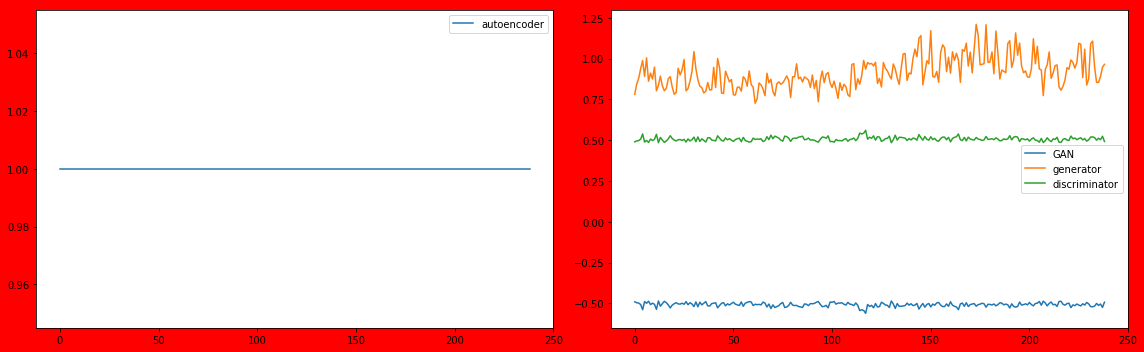

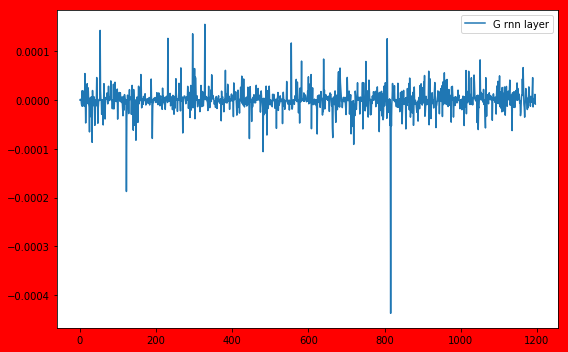

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 14]. loss: 71.718585 time: 431.8 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['hold on , ted . you may refer your brain . </s>']
true response:  nonsmoking , please . </s>
generate response:  ['no , thanks . </s>']
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['what do you choose ? </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ['what else should i do ? </s>']
true response:  you will need to pay late fees on these books . </s>
generate response:  ['what do you choose ? </s>']
true response:  that sounds nice . </s>
generate response:  ["will the doctor ' ll be able to </s>"]

[15 315] loss_ae: 1.000000 loss_g: 0.879232 loss_d_rel: 0.508864 time: 1.8 s
[15 320] loss_ae: 1.000000 loss_g: 0.810891 loss_d_rel: 0.507919 time: 1.8 s
[15 325] loss_ae: 1.000000 loss_g: 0.872509 loss_d_rel: 0.531785 time: 1.9 s
[15 330] loss_ae: 1.000000 loss_g: 0.843557 loss_d_rel: 0.490315 time: 1.8 s
[15 335] loss_ae: 1.000000 loss_g: 0.929626 loss_d_rel: 0.527153 time: 1.8 s
[15 340] loss_ae: 1.000000 loss_g: 0.882784 loss_d_rel: 0.498479 time: 1.8 s
[15 345] loss_ae: 1.000000 loss_g: 1.025110 loss_d_rel: 0.513388 time: 1.8 s
[15 350] loss_ae: 1.000000 loss_g: 1.093198 loss_d_rel: 0.510140 time: 1.8 s
[15 355] loss_ae: 1.000000 loss_g: 1.146265 loss_d_rel: 0.508913 time: 1.8 s
[15 360] loss_ae: 1.000000 loss_g: 0.930114 loss_d_rel: 0.522761 time: 1.9 s
[15 365] loss_ae: 1.000000 loss_g: 1.033772 loss_d_rel: 0.519439 time: 1.9 s
[15 370] loss_ae: 1.000000 loss_g: 0.789062 loss_d_rel: 0.500775 time: 1.8 s
[15 375] loss_ae: 1.000000 loss_g: 0.795273 loss_d_rel: 0.486454 time: 1.8 s

[15 850] loss_ae: 1.000000 loss_g: 0.998327 loss_d_rel: 0.514123 time: 1.9 s
[15 855] loss_ae: 1.000000 loss_g: 0.830041 loss_d_rel: 0.508197 time: 1.9 s
[15 860] loss_ae: 1.000000 loss_g: 0.831677 loss_d_rel: 0.517663 time: 1.8 s
[15 865] loss_ae: 1.000000 loss_g: 0.821973 loss_d_rel: 0.530391 time: 1.9 s
[15 870] loss_ae: 1.000000 loss_g: 0.842778 loss_d_rel: 0.508744 time: 1.9 s
[15 875] loss_ae: 1.000000 loss_g: 0.813574 loss_d_rel: 0.508396 time: 1.9 s
[15 880] loss_ae: 1.000000 loss_g: 0.941215 loss_d_rel: 0.509215 time: 1.9 s
[15 885] loss_ae: 1.000000 loss_g: 1.053986 loss_d_rel: 0.504540 time: 1.8 s
[15 890] loss_ae: 1.000000 loss_g: 0.920840 loss_d_rel: 0.531702 time: 1.8 s
[15 895] loss_ae: 1.000000 loss_g: 0.808697 loss_d_rel: 0.501702 time: 1.9 s
[15 900] loss_ae: 1.000000 loss_g: 0.770768 loss_d_rel: 0.494326 time: 1.9 s
[15 905] loss_ae: 1.000000 loss_g: 0.905637 loss_d_rel: 0.517172 time: 1.8 s
[15 910] loss_ae: 1.000000 loss_g: 1.042627 loss_d_rel: 0.520565 time: 1.9 s

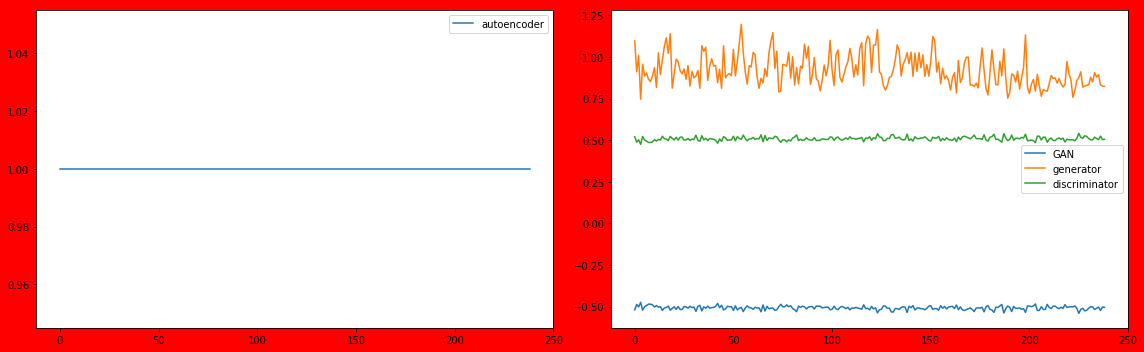

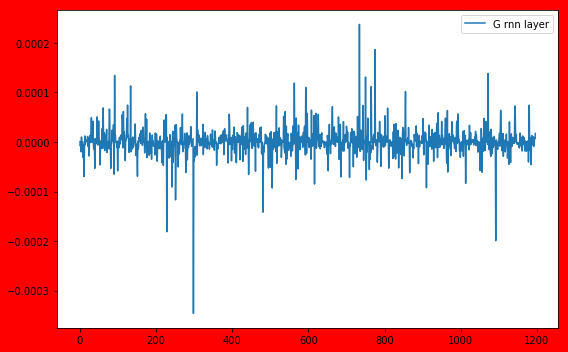

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 15]. loss: 60.279043 time: 461.6 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['generally speaking , you can renew them without you . </s>']
true response:  nonsmoking , please . </s>
generate response:  ['no , thanks . </s>']
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['i ’ m planning on visiting my friends . </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ['what do you choose ? </s>']
true response:  you will need to pay late fees on these books . </s>
generate response:  ['how do you choose ? </s>']
true response:  that sounds nice . </s>
generate response:  ["i ' m fine .

[16 315] loss_ae: 1.000000 loss_g: 0.835899 loss_d_rel: 0.504952 time: 2.4 s
[16 320] loss_ae: 1.000000 loss_g: 0.929511 loss_d_rel: 0.512788 time: 2.3 s
[16 325] loss_ae: 1.000000 loss_g: 0.784943 loss_d_rel: 0.504693 time: 2.4 s
[16 330] loss_ae: 1.000000 loss_g: 0.825061 loss_d_rel: 0.505483 time: 2.3 s
[16 335] loss_ae: 1.000000 loss_g: 0.772308 loss_d_rel: 0.500551 time: 2.3 s
[16 340] loss_ae: 1.000000 loss_g: 0.874114 loss_d_rel: 0.515058 time: 2.3 s
[16 345] loss_ae: 1.000000 loss_g: 0.837573 loss_d_rel: 0.499541 time: 2.3 s
[16 350] loss_ae: 1.000000 loss_g: 0.932961 loss_d_rel: 0.519628 time: 2.4 s
[16 355] loss_ae: 1.000000 loss_g: 0.839396 loss_d_rel: 0.493136 time: 2.3 s
[16 360] loss_ae: 1.000000 loss_g: 0.824184 loss_d_rel: 0.495405 time: 2.3 s
[16 365] loss_ae: 1.000000 loss_g: 0.933141 loss_d_rel: 0.512816 time: 2.4 s
[16 370] loss_ae: 1.000000 loss_g: 0.863882 loss_d_rel: 0.500752 time: 2.3 s
[16 375] loss_ae: 1.000000 loss_g: 0.756983 loss_d_rel: 0.487218 time: 2.3 s

[16 850] loss_ae: 1.000000 loss_g: 0.890781 loss_d_rel: 0.511752 time: 2.0 s
[16 855] loss_ae: 1.000000 loss_g: 0.862571 loss_d_rel: 0.518403 time: 2.0 s
[16 860] loss_ae: 1.000000 loss_g: 0.882137 loss_d_rel: 0.509088 time: 2.0 s
[16 865] loss_ae: 1.000000 loss_g: 1.082145 loss_d_rel: 0.520726 time: 2.0 s
[16 870] loss_ae: 1.000000 loss_g: 0.941805 loss_d_rel: 0.524828 time: 2.0 s
[16 875] loss_ae: 1.000000 loss_g: 1.030897 loss_d_rel: 0.518548 time: 2.0 s
[16 880] loss_ae: 1.000000 loss_g: 1.074838 loss_d_rel: 0.512908 time: 2.0 s
[16 885] loss_ae: 1.000000 loss_g: 1.029029 loss_d_rel: 0.512442 time: 2.0 s
[16 890] loss_ae: 1.000000 loss_g: 0.976135 loss_d_rel: 0.520540 time: 2.0 s
[16 895] loss_ae: 1.000000 loss_g: 0.891222 loss_d_rel: 0.521277 time: 2.0 s
[16 900] loss_ae: 1.000000 loss_g: 0.809542 loss_d_rel: 0.505252 time: 1.9 s
[16 905] loss_ae: 1.000000 loss_g: 0.896674 loss_d_rel: 0.508010 time: 2.0 s
[16 910] loss_ae: 1.000000 loss_g: 0.875121 loss_d_rel: 0.499201 time: 2.0 s

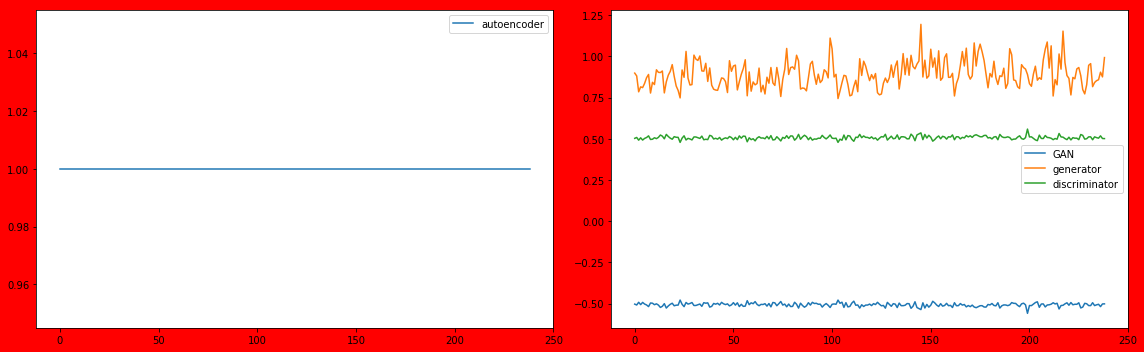

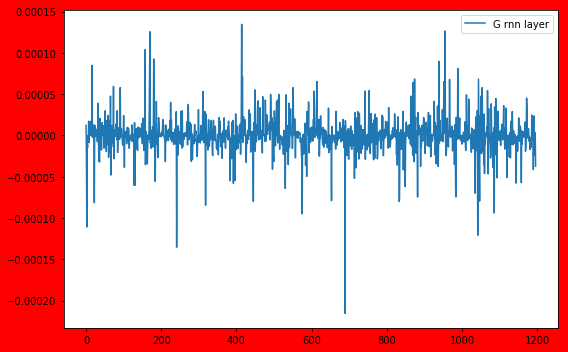

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 16]. loss: 68.394578 time: 521.9 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['generally speaking , what is your chief responsibility ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ['no , thanks . </s>']
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['what do you choose ? </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ['what do you need ? </s>']
true response:  you will need to pay late fees on these books . </s>
generate response:  ['how do you get ? </s>']
true response:  that sounds nice . </s>
generate response:  ['will be fine ? </s>']
true respon

[17 320] loss_ae: 1.000000 loss_g: 0.951434 loss_d_rel: 0.523228 time: 2.0 s
[17 325] loss_ae: 1.000000 loss_g: 0.786286 loss_d_rel: 0.510985 time: 2.0 s
[17 330] loss_ae: 1.000000 loss_g: 0.758823 loss_d_rel: 0.504814 time: 1.9 s
[17 335] loss_ae: 1.000000 loss_g: 0.825211 loss_d_rel: 0.493215 time: 1.9 s
[17 340] loss_ae: 1.000000 loss_g: 0.938521 loss_d_rel: 0.496218 time: 2.0 s
[17 345] loss_ae: 1.000000 loss_g: 0.998228 loss_d_rel: 0.519546 time: 1.9 s
[17 350] loss_ae: 1.000000 loss_g: 0.979546 loss_d_rel: 0.515390 time: 2.0 s
[17 355] loss_ae: 1.000000 loss_g: 0.859342 loss_d_rel: 0.505544 time: 2.0 s
[17 360] loss_ae: 1.000000 loss_g: 0.983200 loss_d_rel: 0.513143 time: 2.0 s
[17 365] loss_ae: 1.000000 loss_g: 0.941299 loss_d_rel: 0.511555 time: 1.9 s
[17 370] loss_ae: 1.000000 loss_g: 1.117843 loss_d_rel: 0.507539 time: 2.0 s
[17 375] loss_ae: 1.000000 loss_g: 0.893057 loss_d_rel: 0.496518 time: 1.9 s
[17 380] loss_ae: 1.000000 loss_g: 1.073148 loss_d_rel: 0.506444 time: 2.0 s

[17 855] loss_ae: 1.000000 loss_g: 0.962749 loss_d_rel: 0.504501 time: 2.0 s
[17 860] loss_ae: 1.000000 loss_g: 0.903038 loss_d_rel: 0.505353 time: 2.0 s
[17 865] loss_ae: 1.000000 loss_g: 0.851083 loss_d_rel: 0.495998 time: 2.0 s
[17 870] loss_ae: 1.000000 loss_g: 0.842892 loss_d_rel: 0.505656 time: 1.9 s
[17 875] loss_ae: 1.000000 loss_g: 0.833790 loss_d_rel: 0.518473 time: 1.9 s
[17 880] loss_ae: 1.000000 loss_g: 1.029411 loss_d_rel: 0.504210 time: 2.0 s
[17 885] loss_ae: 1.000000 loss_g: 0.917616 loss_d_rel: 0.491996 time: 2.0 s
[17 890] loss_ae: 1.000000 loss_g: 0.824021 loss_d_rel: 0.488881 time: 1.9 s
[17 895] loss_ae: 1.000000 loss_g: 1.117909 loss_d_rel: 0.531913 time: 2.0 s
[17 900] loss_ae: 1.000000 loss_g: 0.907769 loss_d_rel: 0.503301 time: 1.9 s
[17 905] loss_ae: 1.000000 loss_g: 0.783378 loss_d_rel: 0.496309 time: 2.0 s
[17 910] loss_ae: 1.000000 loss_g: 0.957178 loss_d_rel: 0.520556 time: 2.0 s
[17 915] loss_ae: 1.000000 loss_g: 0.897414 loss_d_rel: 0.491759 time: 2.0 s

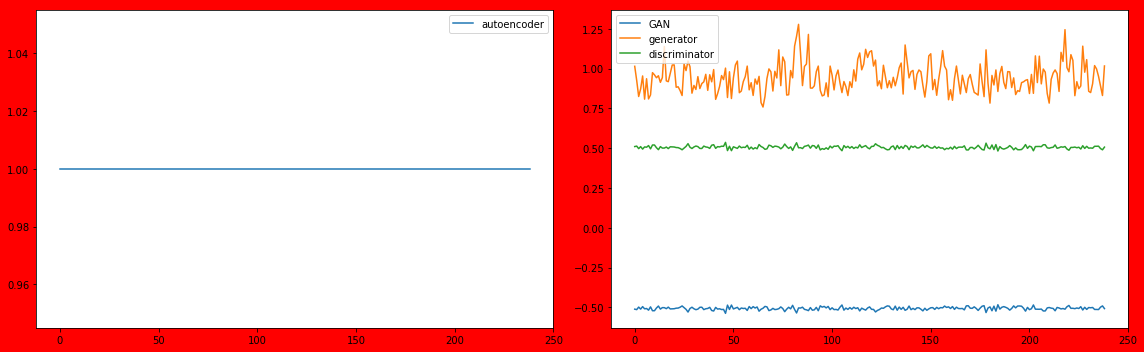

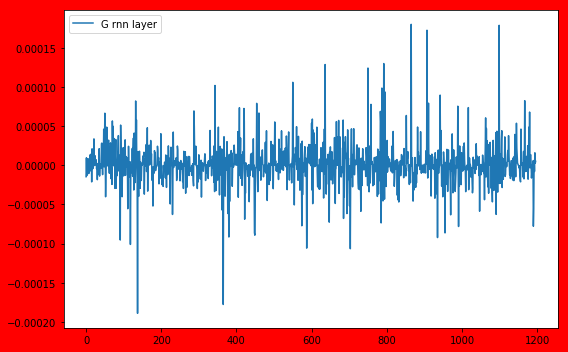

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 17]. loss: 76.653888 time: 476.0 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['generally speaking , may i ask her ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ['no , thank you . </s>']
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['what do you choose ? </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ['what else should i buy ? </s>']
true response:  you will need to pay late fees on these books . </s>
generate response:  ['how did you ? </s>']
true response:  that sounds nice . </s>
generate response:  ["i ' m fine . thanks anyway . </s>"]
true respon

[18 315] loss_ae: 1.000000 loss_g: 0.910027 loss_d_rel: 0.495473 time: 1.8 s
[18 320] loss_ae: 1.000000 loss_g: 0.892525 loss_d_rel: 0.513929 time: 1.8 s
[18 325] loss_ae: 1.000000 loss_g: 0.821996 loss_d_rel: 0.496128 time: 1.8 s
[18 330] loss_ae: 1.000000 loss_g: 0.881157 loss_d_rel: 0.502508 time: 1.8 s
[18 335] loss_ae: 1.000000 loss_g: 0.926533 loss_d_rel: 0.502801 time: 1.8 s
[18 340] loss_ae: 1.000000 loss_g: 0.893167 loss_d_rel: 0.498472 time: 1.8 s
[18 345] loss_ae: 1.000000 loss_g: 0.733386 loss_d_rel: 0.498230 time: 1.8 s
[18 350] loss_ae: 1.000000 loss_g: 0.899467 loss_d_rel: 0.499031 time: 1.8 s
[18 355] loss_ae: 1.000000 loss_g: 0.904638 loss_d_rel: 0.513748 time: 1.8 s
[18 360] loss_ae: 1.000000 loss_g: 0.826214 loss_d_rel: 0.503811 time: 1.8 s
[18 365] loss_ae: 1.000000 loss_g: 0.895370 loss_d_rel: 0.496644 time: 1.8 s
[18 370] loss_ae: 1.000000 loss_g: 0.851600 loss_d_rel: 0.499297 time: 1.8 s
[18 375] loss_ae: 1.000000 loss_g: 0.871349 loss_d_rel: 0.501597 time: 1.8 s

[18 850] loss_ae: 1.000000 loss_g: 1.054648 loss_d_rel: 0.494091 time: 2.2 s
[18 855] loss_ae: 1.000000 loss_g: 1.086311 loss_d_rel: 0.502232 time: 2.2 s
[18 860] loss_ae: 1.000000 loss_g: 0.865513 loss_d_rel: 0.497502 time: 2.1 s
[18 865] loss_ae: 1.000000 loss_g: 1.133107 loss_d_rel: 0.517532 time: 2.2 s
[18 870] loss_ae: 1.000000 loss_g: 1.178414 loss_d_rel: 0.517126 time: 2.3 s
[18 875] loss_ae: 1.000000 loss_g: 1.152696 loss_d_rel: 0.494999 time: 2.2 s
[18 880] loss_ae: 1.000000 loss_g: 0.921832 loss_d_rel: 0.504395 time: 2.3 s
[18 885] loss_ae: 1.000000 loss_g: 0.964759 loss_d_rel: 0.508005 time: 2.3 s
[18 890] loss_ae: 1.000000 loss_g: 1.164578 loss_d_rel: 0.499821 time: 2.3 s
[18 895] loss_ae: 1.000000 loss_g: 1.089761 loss_d_rel: 0.501175 time: 2.2 s
[18 900] loss_ae: 1.000000 loss_g: 1.004965 loss_d_rel: 0.514555 time: 2.3 s
[18 905] loss_ae: 1.000000 loss_g: 1.026552 loss_d_rel: 0.512019 time: 2.3 s
[18 910] loss_ae: 1.000000 loss_g: 0.918880 loss_d_rel: 0.496050 time: 2.2 s

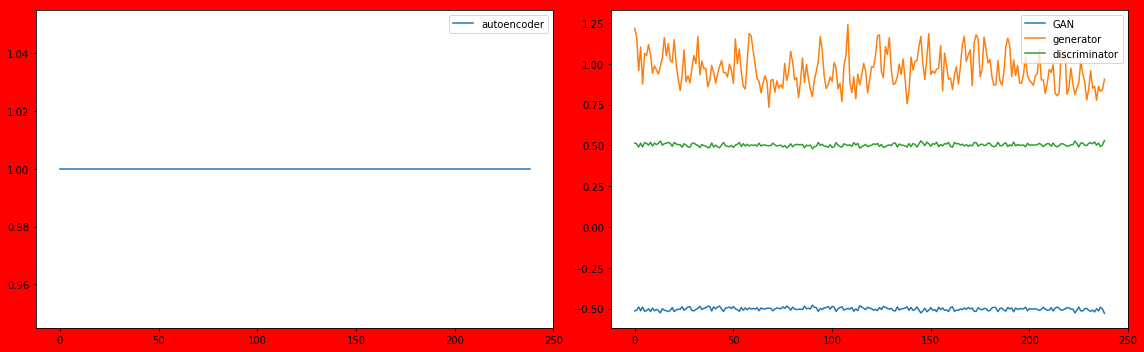

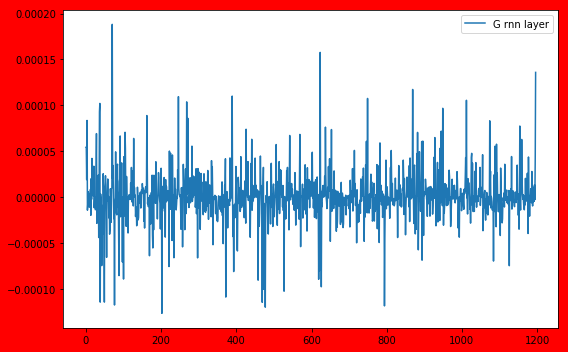

Evaluating....
Valid begins with 367 batches with 0 left over samples
************************************************************
[epoch 18]. loss: 61.032648 time: 522.0 s
************************************************************
Test begins with 6740 batches with 0 left over samples
true response:  i ' m sorry , but mr . johnson is out at the moment . can i take </s>
generate response:  ['certainly . would you please kindly put him a little bit ? </s>']
true response:  nonsmoking , please . </s>
generate response:  ['no , thank you . </s>']
true response:  well , i wanted to let you know that i ' ve put in my notice . </s>
generate response:  ['what do you choose ? </s>']
true response:  can i return the car in san francisco ? </s>
generate response:  ['what else should i buy ? </s>']
true response:  you will need to pay late fees on these books . </s>
generate response:  ['how did you ? </s>']
true response:  that sounds nice . </s>
generate response:  ['thank you for telling me 

In [23]:
metrics=Metrics(corpus.word2vec)
model = Dialog_doubleGAN(config, n_tokens)
if corpus.word2vec is not None:
    print("Loaded word2vec")
    model.embedder.weight.data.copy_(torch.from_numpy(corpus.word2vec))
#     model.discriminator_relevance.embedder.weight.data.copy_(torch.from_numpy(corpus.word2vec))
    model.embedder.weight.data[0].fill_(0)
model.to(DEVICE)
model.zero_grad()

total_batch_count = 0 # 统计总共循环次数，用来动态调整温度参数
print_every = 5
best_state = None
max_metric = 0
valid_loss_ae = []
valid_loss_g = []
valid_loss_d_rel = []
max_temp = 10.0
temperature = 0.5

pretrain_epoch = 4
print('start pretraining AE...')
for i in range(6):
    print('pretrain AE epoch: ', i+1)
    total_train_batch = 0
    train_loader.epoch_init(32, config['diaglen'], 1, shuffle=False)
    while True:
        model.train()
        batch = train_loader.next_batch()
        total_train_batch += 32
        if batch is None:
#         if batch is None or total_train_batch >= 10000: # end of epoch
                break
        context, context_lens, utt_lens, floors,_,_,_,response,res_lens,_ = batch
        context, utt_lens = context[:,:,1:], utt_lens-1 # remove the sos token in the context and reduce the context length
        context, context_lens, utt_lens, floors, response, res_lens\
                = gVar(context), gVar(context_lens), gVar(utt_lens), gData(floors), gVar(response), gVar(res_lens)
        # train encoder and decoder
        loss_AE = model.train_AE(context, context_lens, utt_lens, floors, response)
#         buf_loss[0] += float(loss_AE[0][1]) 
# recall_bleu, bow_extrema, bow_avg, bow_greedy, inter_dist1, inter_dist2, avg_len = evaluate(model, metrics, 
#                                   valid_loader, vocab, ivocab, repeat=1)

print('start pretraining D...')
for i in range(3):
    print('pretrain D epoch: ', i+1)
    loss_d_record = 0.0
    train_loader.epoch_init(32, config['diaglen'], 1, shuffle=False)
    n_iters = train_loader.num_batch
    while True:
        model.train()
        batch = train_loader.next_batch()
#         total_train_batch += 32
        if batch is None: # end of epoch
            break
        context, context_lens, utt_lens, floors,_,_,_,response,res_lens,_ = batch
        context, utt_lens = context[:,:,1:], utt_lens-1 # remove the sos token in the context and reduce the context length
        context, context_lens, utt_lens, floors, response, res_lens\
                = gVar(context), gVar(context_lens), gVar(utt_lens), gData(floors), gVar(response), gVar(res_lens)
        loss_D, neg = model.train_D_relevance(context, context_lens, utt_lens, floors, 
                                             response, res_lens-1, temperature=0.4, is_pretrain=True)
        ref_str, _ = indexes2sent(neg, vocab, vocab["</s>"], vocab["<s>"])
#         print(ref_str[:2])
        loss_d_record += float(loss_D[0][1])
    print("loss D: %.6f"%(loss_d_record/n_iters))
    
for epoch in range(18):
    print('Epoch: ', epoch+1)
    train_loader.epoch_init(32, config['diaglen'], 1, shuffle=True)
#     print('temperature: ', temperature)
    n_iters = train_loader.num_batch
    train_loss_ae = []
    train_loss_g = []
    train_loss_d_rel = []
    # 分别用来记录训练时候，生成器最顶层的梯度，最底层的梯度以及判别器最顶层的梯度
    train_grad_G_top_layer = []
    train_grad_G_bottom_layer = []
    train_grad_D_top_layer = []
    
    buf_loss = [0.0, 0.0, 0.0]
    epoch_begin = time()
    batch_count = 0
    batch_begin_time = time()
    total_train_batch = 0 # 记录训练的样本数量
    total_valid_batch = 0 # 记录测试的样本数量
    while True:
        model.train()
        loss_records = []
        batch = train_loader.next_batch()
        total_train_batch += 32
        if batch is None:
#         if batch is None or total_train_batch >= 10000: # end of epoch
            break
        context, context_lens, utt_lens, floors,_,_,_,response,res_lens,_ = batch
        context, utt_lens = context[:,:,1:], utt_lens-1 # remove the sos token in the context and reduce the context length
        context, context_lens, utt_lens, floors, response, res_lens\
                = gVar(context), gVar(context_lens), gVar(utt_lens), gData(floors), gVar(response), gVar(res_lens)
        # train encoder and decoder
#         if epoch <= 2:
#             loss_AE = model.train_AE(context, context_lens, utt_lens, floors, response)
#             buf_loss[0] += float(loss_AE[0][1])   
#         else:
#             buf_loss[0] = 0
        # train generator
        loss_G = model.train_G(context, context_lens, utt_lens, floors, response, temperature=0.4)
        buf_loss[1] += float(loss_G[0][1])
        # train discriminator
        for i in range(1):# train discriminator/critic
#         if batch_count % 5 == 0:
#             print('yes')
            loss_D, neg_sen = model.train_D_relevance(context, context_lens, utt_lens, floors, 
                                             response, res_lens-1, temperature=0.4, is_pretrain=True)  
            ref_str, _ = indexes2sent(neg_sen, vocab, vocab["</s>"], vocab["<s>"])
#             print(ref_str[:2])
            if i==0:
                buf_loss[2] += float(loss_D[0][1])
#             if i==config['n_iters_d']-1:
#                 break
            batch = train_loader.next_batch()
            total_train_batch += 32
            if batch is None: # end of epoch
                break
            context, context_lens, utt_lens, floors,_,_,_,response,res_lens,_ = batch
            context, utt_lens = context[:,:,1:], utt_lens-1 # remove the sos token in the context and reduce the context length
            context, context_lens, utt_lens, floors, response, res_lens\
                = gVar(context), gVar(context_lens), gVar(utt_lens), gData(floors), gVar(response), gVar(res_lens)                      
        batch_count += 1
        total_batch_count += 1
        # 对抗训练途中也mle训练，避免出现不通顺的句子
#         if batch_count % print_every*10 == 0:
#             loss_AE = model.train_AE(context, context_lens, utt_lens, floors, response)

        if batch_count % print_every == 0:
            buf_loss[0] = np.exp(buf_loss[0] / print_every)
            buf_loss[1] = buf_loss[1] / print_every
            buf_loss[2] = buf_loss[2] / print_every
            print_flush('[%d %d] loss_ae: %.6f loss_g: %.6f loss_d_rel: %.6f time: %.1f s' %\
                  (epoch + 1, batch_count, buf_loss[0], buf_loss[1], buf_loss[2], time() - batch_begin_time))
            train_loss_ae.append(buf_loss[0])
            train_loss_g.append(buf_loss[1])
            train_loss_d_rel.append(buf_loss[2])
            batch_begin_time = time()
            buf_loss = [0, 0, 0]
#         train_grad_G_top_layer.append(torch.mean(model.context_encoder.rnn.weight_hh_l0.grad))
#         train_grad_G_top_layer.append(torch.mean(model.generator.out.weight.grad))
        train_grad_G_bottom_layer.append(torch.mean(model.generator.rnn.weight_hh_l0.grad))
#         train_grad_G_bottom_layer.append(torch.mean(model.embedder.weight.grad))
#         train_grad_D_top_layer.append(torch.mean(model.context_encoder.self_attention.w_qs.weight.grad))

#         temperature = get_fixed_temperature(max_temp, total_batch_count, 3000, 'exp')
    plot_loss(train_loss_ae, train_loss_g, train_loss_d_rel)
#     plot_gradient(train_grad_G_top_layer, 'G out layer')
    plot_gradient(train_grad_G_bottom_layer, 'G rnn layer')
#     plot_gradient(train_grad_D_top_layer, 'D embedding layer')
    print_flush("Evaluating....")
    valid_loader.epoch_init(20, config['diaglen'], 1, shuffle=False)
    buf_loss = valid(model, valid_loader, temp=0.4)
#     valid_loss_ae.append(buf_loss[0])
#     valid_loss_g.append(buf_loss[1])
#     valid_loss_d_rel.append(buf_loss[2])
# #     valid_result.append(F1)
    print_flush('*'*60)
    print_flush('[epoch %d]. loss: %.6f time: %.1f s'%(epoch+1, np.exp(buf_loss[0]), time()-epoch_begin))
    print_flush('*'*60)
    recall_bleu, bow_extrema, bow_avg, bow_greedy, inter_dist1, inter_dist2, avg_len = \
    evaluate(model, metrics, test_loader, vocab, ivocab, repeat=1)
    epoch_begin = time()
#     if F1 > max_metric:
#         best_state = model.state_dict()
#         max_metric = F1
#         print_flush("save model...")
#         torch.save(best_state, '../datasets/models/baseline_LSTM.pth')
#     epoch_begin = time()
#     if training_termination(valid_result):
#         print_flush("early stop at [%d] epoch!" % (epoch+1))
#         break


In [ ]:
plot_loss(valid_loss_ae, valid_loss_g, valid_loss_d_rel)